# Analysis of PST data from REWMEM 

I'm re-running the PST analyses in their own notebooks at the same time so that I can be sure the methodology I use is consistent across the experiments (and just because the big NB with all the RevMem stuff was too much to handle). I'll also aggregate all the data for a well-powered look at individual differences. Also, read this paper when you're analyzing RMD: http://ski.clps.brown.edu/papers/SolomonEtAl_AJP.pdf

In [47]:
import getpass
user = getpass.getuser()
path2code = '/Users/' + user + '/Work/Expts/Code'
path2figs = '/Users/' + user + '/Work/Expts/REWMEM/REWMEM_repo/Figures/PST/'
path2asys = '/Users/' + user + '/Work/Expts/REWMEM/REWMEM_repo/'
path2d1 = '/Users/' + user + '/Work/Expts/REWMEM/Version1/Data/PST_Data'
path2d2 = '/Users/' + user + '/Work/Expts/REWMEM/Version2/Data'
path2d3 = '/Users/' + user + '/Work/Expts/REWMEM/Version3/Data'

%cd {path2code}
import itertools, misc, os, PST_proc, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext rpy2.ipython
%R library('lmerTest')
%R library('afex')
%R library('lsmeans')

/Users/danieldillon/Work/Expts/Code
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['afex', 'lsmeans', 'estimability', 'reshape2', 'lmerTest', 'lme4',
       'Matrix', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S12')

## Demographics and Self-report 

In [48]:
## Assemble all the demographic, screening, and self-report data for RM1-3. 
## The self-report data were all double-entered and checked on 11/22/14-11/24/14 by DD and EB.

demo = SelfRep.demo_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
aes = SelfRep.aes_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
bdi = SelfRep.bdi_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
bb = SelfRep.bb_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
masq = SelfRep.masq_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
wtar = SelfRep.wtar_proc('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_SelfRep_Master.xlsx')
screen = pd.read_csv('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_Screening_Master.csv')

def GrabExpt(input):
    step1 = input.split('.')[0]
    expt = step1.split('REWMEM')[1]
    expt = int(expt)
    return expt

def GrabSub(input):
    sub = input.split('.')[1]
    sub = int(sub)
    return sub

for df in [demo, aes, bdi, bb, masq, wtar]:
    df['Experiment'] = df.subject.apply(GrabExpt)
    df['Subject'] = df.subject.apply(GrabSub)
    del df['subject']

mg1 = pd.merge(demo,screen,on=['Experiment','Subject'])
mg2 = pd.merge(mg1,aes,on=['Experiment','Subject'])
mg3 = pd.merge(mg2,bdi,on=['Experiment','Subject'])
mg4 = pd.merge(mg3,bb,on=['Experiment','Subject'])
mg5 = pd.merge(mg4,masq,on=['Experiment','Subject'])
selfrep = pd.merge(mg5,wtar,on=['Experiment','Subject'])
selfrep['ID'] = selfrep.Experiment.astype(str) + '_' + selfrep.Subject.astype(str)
selfrep.to_csv('/Users/danieldillon/Work/Expts/REWMEM/REWMEM_repo/Data/REWMEM_AllSelfReport.csv',index=False)

# selfrep: n = 130 (RM.1, n = 56; RM.2, n = 52; RM.3, n = 22)

# Income
# selfrep['Income'].replace('<10K','0-10K', inplace=True)
# print pd.crosstab(selfrep['Experiment'],selfrep['Income'])

# How many subjects have current or lifetime neurological issues? 7 do, 119 do not, 4 did not respond
neurol = selfrep[(selfrep.Curr_or_life_neurological == 1) | (selfrep.Curr_or_life_neurological == 999)]
no_neurol = selfrep[selfrep.Curr_or_life_neurological == 0]
print "Num subjects with no neurological issues: " + str(len(no_neurol))

# How many subjects currently using psychotropic meds? 13 are, 113 are not, 4 did not respond
print "\nCurrent psychotropic use:"
print selfrep.Current_psychotropics_yes_no.value_counts()


# Of the participants with no neurological issues, how many are currently using psychotropic meds? 11
# 108 subjects with no neurological issues and no current psychotropics.

OnMeds = no_neurol[no_neurol.Current_psychotropics_yes_no == 1]
NoMeds = no_neurol[no_neurol.Current_psychotropics_yes_no == 0]
print "\nNum subjects free of neurological conditions and current psychotropic med use: " + str(len(NoMeds))

Num subjects with no neurological issues: 119

Current psychotropic use:
0      113
1       13
999      4
Name: Current_psychotropics_yes_no, dtype: int64

Num subjects free of neurological conditions and current psychotropic med use: 108


In [49]:
NoMeds.groupby('Experiment')['ID'].nunique()

Experiment
1    46
2    40
3    22
Name: ID, dtype: int64

## Assemble the PST training data . . . 

In [50]:
train_d = re.compile('[\w]+train.csv$')

# Assemble data from RM.1 and RM.2 (both behavior only)
dfs = []
for e_path in [path2d1,path2d2]:
    
    for path, directory, files in os.walk(e_path):
        for fname in files:
            train_m = train_d.search(fname)
            if train_m:
                sub = fname.split('_')[0]
                sub = sub.lstrip('0')
                curr_file = path + '/' + fname
                df = pd.read_csv(curr_file)
                df['subject'] = sub
                if e_path == path2d1:
                    df['experiment'] = 1
                elif e_path == path2d2:
                    df['experiment'] = 2
                df['ID'] = df.experiment.astype(str) + '_' + df.subject.astype(str)
                dfs.append(df)
e1e2 = pd.concat(dfs)
e1e2 = e1e2[~(e1e2.subject == 'JMPilot')]
e1e2 = e1e2[['experiment','subject','ID','block_id',' trial_id',' left_stim_number',' right_stim_number',' response',
             ' trial_RT',' trial_accuracy',' feedback']]
new_cols = ['experiment','subject','ID','block','trial','left_stim_number','right_stim_number','response','RT',
             'accuracy','feedback']
e1e2.columns = new_cols
e1e2.reset_index(inplace=True,drop=True)

# Now add data from RM.3 . . . different columns b/c this was an imaging study
dfs = []

for path, directory, files in os.walk(path2d3):
    for fname in files:
        if 'p0' in fname: # Two pilots with different file headers, need to be skipped
            pass
        else:
            train_m = train_d.search(fname)
        if train_m:
            sub = fname.split('_')[0]
            sub = sub.lstrip('0')
            curr_file = path + '/' + fname
            df = pd.read_csv(curr_file)
            df['subject'] = sub
            df['experiment'] = 3
            df['ID'] = df.experiment.astype(str) + '_' + df.subject.astype(str)
            dfs.append(df)
e3 = pd.concat(dfs)
new_cols = ['block', 'trial', 'left_stim', 'left_stim_number',
       'right_stim', 'right_stim_number', 'object_onset',
       'object_duration', 'response', 'response_onset', 'RT',
       'accuracy', 'isi_onset', 'isi_duration', 'scheduled_outcome',
       'feedback', 'feedback_onset', 'feedback_duration', 'iti_onset',
       'iti_duration', 'subject', 'experiment', 'ID']
e3.columns = new_cols
e3 = e3[['experiment','subject','ID','block','trial','left_stim_number','right_stim_number','response','RT',
          'accuracy','feedback']]
# e3.head()

# Put them together
train = pd.concat([e1e2,e3])
train.reset_index(inplace=True,drop=True)

# Add lnRT, mark trials with raw RT < 100 ms or lnRT > mean+/-3SDs as outliers
train['lnRT'] = train.RT.apply(np.log)

def OutCheck(df):
    '''Trials with no response set to np.nan, trials with RT < 100 ms set to 1, trials with lnRT exceeding
    mean +/- 3SDs set to 1, otherwise set to 0.'''
    
    dfs = []
    for ID in df.ID.unique():
        outliers = []
        sdf = df[df.ID == ID]
        high = sdf.lnRT.mean() + (3*sdf.lnRT.std())
        low = sdf.lnRT.mean() - (3*sdf.lnRT.std())
        for i, row_i in sdf.iterrows():
            if pd.isnull(row_i.RT):
                outliers.append(np.nan)
            elif (row_i.RT == 999) or (row_i.RT == '999') or (row_i.RT == 'none'):
                outliers.append(np.nan)
            elif row_i.RT < 0.100:
                outliers.append(1)
            elif (row_i.lnRT < low) or (row_i.lnRT > high):
                outliers.append(1)
            else:
                outliers.append(0)
        sdf['outlier'] = outliers
        dfs.append(sdf)
    out = pd.concat(dfs)
    return out

train = OutCheck(train)

# Did anyone respond on fewer than 90% of training trials? If so, print that and put them in "asleep".
asleep = []
for sub in train.ID.unique():
    sdf = train[train.ID == sub]
    nr = sdf[sdf.response == 'No_response']
    if len(nr) > 24: # 10% of 240 trials is 24 . . . 
        print "Subject " + str(sub) + ' had ' + str(len(nr)) + ' trials with no response. That exceeds the maximum.'
        print "This subject will be dropped from all analyses."
        asleep.append(sub)

train = train[~(train.ID.isin(asleep))]

# Now count and drop trials with no response.
all_trials = len(train)
train = train.dropna(subset=['outlier'])
no_nulls = len(train)
num_nr = all_trials - no_nulls
pct_nr = float(num_nr)/all_trials

print '\nThere were ' + str(num_nr) + ' trials with no response during training, across the experiments. \
That is ' + '{:.3f}'.format(pct_nr) + '% of the trials.'

# Now count and drop outliers
num_outs = len(train[train.outlier == 1])
pct_outs = float(num_outs)/len(train)
train = train[~(train.outlier == 1)]

print '\nThere were ' + str(num_outs) + ' outliers during training, across the experiments.\
That is ' + '{:.3f}'.format(pct_outs) + '% of the trials.'

# Now add choices and stimulus pairs
def AddChoicePair(data):
    '''Given the left and right stim numbers, plus the subject's response, code the choice made and pair seen.'''
    left_stim_number, right_stim_number, response = data
    choice = np.nan
    pair = np.nan
    
    stims = {1:('A','AB'),2:('C','CD'),3:('E','EF'),4:('F','EF'),5:('D','CD'),6:('B','AB')}
    
    if response == 'right':
        stim = right_stim_number
    elif response == 'left':
        stim = left_stim_number
    
    choice,pair = stims[stim]
    
    return choice,pair

train['choice'],train['pair']= zip(*train[['left_stim_number','right_stim_number','response']].apply(AddChoicePair,axis=1))


# Now take only those subjects w/o neurological problems, and who are not using psychotropics
train = train[(train.ID.isin(NoMeds.ID.unique()))]
print 'The number of "clean" subjects with training data is ' + str(train.ID.nunique()) + '.\n'

print train.groupby('experiment')['ID'].nunique()

train.head()    

Subject 3_15 had 26 trials with no response. That exceeds the maximum.
This subject will be dropped from all analyses.

There were 200 trials with no response during training, across the experiments. That is 0.007% of the trials.

There were 55 outliers during training, across the experiments.That is 0.002% of the trials.
The number of "clean" subjects with training data is 105.

experiment
1    46
2    38
3    21
Name: ID, dtype: int64


/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,experiment,subject,ID,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,feedback,lnRT,outlier,choice,pair
0,1,1,1_1,1,1,4,3,right,1.177,1,zero,0.162969,0,E,EF
1,1,1,1_1,1,2,6,1,left,1.388,0,zero,0.327864,0,B,AB
2,1,1,1_1,1,3,2,5,right,1.346,0,zero,0.297137,0,D,CD
3,1,1,1_1,1,4,3,4,right,1.488,0,zero,0.397433,0,F,EF
4,1,1,1_1,1,5,6,1,right,1.455,1,reward,0.375006,0,A,AB


### Training Accuracy

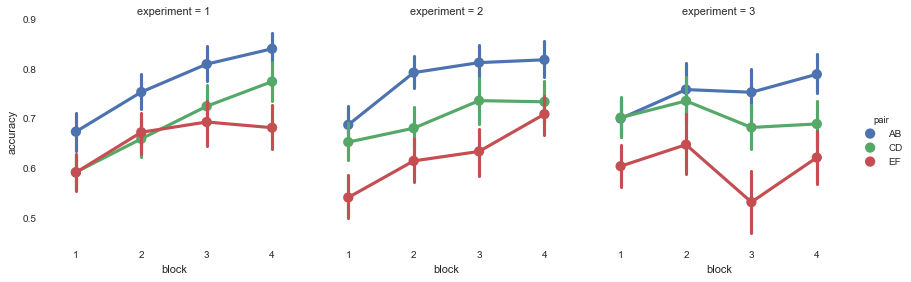

In [51]:
sns.factorplot(y='accuracy',x='block',hue='pair',hue_order=['AB','CD','EF'],
               units='ID',ci=68,col='experiment',data=train)
sns.plt.savefig(path2figs + 'PST_RM123_TrainAcc.pdf')

In [52]:
%Rpush train
# %R str(train)
%R train$experiment <- as.factor(train$experiment)
%R train$block <- as.factor(train$block)
%R train$pair <- as.factor(train$pair)

%R train_acc.aov <- aov_ez(id='ID',dv='accuracy',within=c('pair','block'),between='experiment',\
                           anova_table=list(correction='none',es='pes'),data=train)
%R print(train_acc.aov)

# Follow-up Pair--every pair is different from every other pair
%R pair_acc.lsm <- lsmeans(train_acc.aov, ~ pair)
%R print(pair_acc.lsm)
%R print(pairs(pair_acc.lsm),adjust='none')

## Follow-up Experiment x Block by running Pair x Block separately for each experiment
%R train1 <- subset(train, experiment == 1)
%R train2 <- subset(train, experiment == 2)
%R train3 <- subset(train, experiment == 3)

# RM.1
%R train1_acc.aov <- aov_ez(id='ID',dv='accuracy',within=c('pair','block'),\
                           anova_table=list(correction='none',es='pes'),data=train1)
%R print(train1_acc.aov)
%R train1_block.lsm <- lsmeans(train1_acc.aov, ~ block)
%R print(pairs(train1_block.lsm)) # In RM.1, blocks 2/3 and 3/4 are not different, all others are

# RM.2
%R train2_acc.aov <- aov_ez(id='ID',dv='accuracy',within=c('pair','block'),\
                           anova_table=list(correction='GG',es='pes'),data=train2)
%R print(train2_acc.aov)
%R train2_block.lsm <- lsmeans(train2_acc.aov, ~ block)
%R print(pairs(train2_block.lsm)) # In RM.2, blocks 2/3 and 3/4 are not different, all others are. Same as RM.1

# RM.3
%R train3_acc.aov <- aov_ez(id='ID',dv='accuracy',within=c('pair','block'),\
                           anova_table=list(correction='none',es='pes'),data=train3)
%R print(train3_acc.aov)
%R train3_block.lsm <- lsmeans(train3_acc.aov, ~ block)
%R print(pairs(train3_block.lsm)) # In RM.3, the effect of Block is not significant, althouth the Pair effet is . . . 

# Take a closer look at the Pair effect in RM.3, in light of the null Block effect
%R train3_pair_acc.lsm <- lsmeans(train3_acc.aov, ~ pair)
%R print(train3_pair_acc.lsm)
%R print(pairs(train3_pair_acc.lsm),adjust='none') # AB vs. CD not different, everything else is . . . 

print ' . . .'
print ' . . .'

## Now follow-up Experiment x Block by running Experiment (x Pair) at each level of Block. No effect at any block.
%R train_b1 <- subset(train, block == 1)
%R train_b2 <- subset(train, block == 2)
%R train_b3 <- subset(train, block == 3)
%R train_b4 <- subset(train, block == 4)

%R train_b1_acc.aov <- aov_ez(id='ID',dv='accuracy',within='pair',between='experiment',\
                              anova_table=list(correction='none',es='pes'),data=train_b1)
%R print(train_b1_acc.aov) # No experiment effect in block 1

%R train_b2_acc.aov <- aov_ez(id='ID',dv='accuracy',within='pair',between='experiment',\
                              anova_table=list(correction='none',es='pes'),data=train_b2)
%R print(train_b2_acc.aov) # No experiment effect in block 2

%R train_b3_acc.aov <- aov_ez(id='ID',dv='accuracy',within='pair',between='experiment',\
                              anova_table=list(correction='none',es='pes'),data=train_b3)
%R print(train_b3_acc.aov) # No experiment effect in block 3

%R train_b4_acc.aov <- aov_ez(id='ID',dv='accuracy',within='pair',between='experiment',\
                              anova_table=list(correction='none',es='pes'),data=train_b4)
%R print(train_b4_acc.aov) # No experiment effect in block 4

Anova Table (Type 3 tests)

Response: accuracy
                 Effect      df  MSE         F  pes p.value
1            experiment  2, 102 0.24      0.15 .003     .86
2                  pair  2, 204 0.10 17.25 ***  .14  <.0001
3       experiment:pair  4, 204 0.10      0.47 .009     .76
4                 block  3, 306 0.03 18.47 ***  .15  <.0001
5      experiment:block  6, 306 0.03   3.43 **  .06    .003
6            pair:block  6, 612 0.02      1.02 .010     .41
7 experiment:pair:block 12, 612 0.02      1.09  .02     .36


 pair    lsmean         SE     df  lower.CL  upper.CL
 AB   0.7690286 0.01933951 265.82 0.7309505 0.8071068
 CD   0.7003421 0.01933951 265.82 0.6622640 0.7384203
 EF   0.6322512 0.01933951 265.82 0.5941731 0.6703294

Results are averaged over the levels of: experiment, block 
Confidence level used: 0.95 


 contrast  estimate         SE  df t.ratio p.value
 AB - CD  0.0686865 0.02328915 204   2.949  0.0036
 AB - EF  0.1367774 0.02328915 204   5.873  <.0001
 CD - EF  0.0680909 0.02328915 204   2.924  0.0038

Results are averaged over the levels of: experiment, block 


Anova Table (Type 3 tests)

Response: accuracy
      Effect     df  MSE         F pes p.value
1       pair  2, 90 0.12   5.07 ** .10    .008
2      block 3, 135 0.03 17.62 *** .28  <.0001
3 pair:block 6, 270 0.03      1.01 .02     .42


 contrast    estimate        SE  df t.ratio p.value
 X1 - X2  -0.07551406 0.0216442 135  -3.489  0.0036
 X1 - X3  -0.12269784 0.0216442 135  -5.669  <.0001
 X1 - X4  -0.14542658 0.0216442 135  -6.719  <.0001
 X2 - X3  -0.04718377 0.0216442 135  -2.180  0.1341
 X2 - X4  -0.06991252 0.0216442 135  -3.230  0.0084
 X3 - X4  -0.02272875 0.0216442 135  -1.050  0.7203

Results are averaged over the levels of: pair 
P value adjustment: tukey method for comparing a family of 4 estimates 


Anova Table (Type 3 tests)

Response: accuracy
      Effect           df  MSE         F pes p.value
1       pair  1.88, 69.49 0.11  8.83 *** .19   .0005
2      block  2.18, 80.74 0.03 16.02 *** .30  <.0001
3 pair:block 4.04, 149.31 0.03      0.97 .03     .43

Sphericity correction method: GG 


 contrast    estimate         SE  df t.ratio p.value
 X1 - X2  -0.06938651 0.01936937 111  -3.582  0.0028
 X1 - X3  -0.10131172 0.01936937 111  -5.231  <.0001
 X1 - X4  -0.12662976 0.01936937 111  -6.538  <.0001
 X2 - X3  -0.03192521 0.01936937 111  -1.648  0.3561
 X2 - X4  -0.05724325 0.01936937 111  -2.955  0.0197
 X3 - X4  -0.02531805 0.01936937 111  -1.307  0.5604

Results are averaged over the levels of: pair 
P value adjustment: tukey method for comparing a family of 4 estimates 


Anova Table (Type 3 tests)

Response: accuracy
      Effect     df  MSE       F pes p.value
1       pair  2, 40 0.07 7.18 ** .26    .002
2      block  3, 60 0.03    1.59 .07     .20
3 pair:block 6, 120 0.02    1.16 .05     .33


 contrast    estimate        SE df t.ratio p.value
 X1 - X2  -0.04494160 0.0300585 60  -1.495  0.4468
 X1 - X3   0.01254989 0.0300585 60   0.418  0.9753
 X1 - X4  -0.03174139 0.0300585 60  -1.056  0.7173
 X2 - X3   0.05749150 0.0300585 60   1.913  0.2337
 X2 - X4   0.01320021 0.0300585 60   0.439  0.9714
 X3 - X4  -0.04429128 0.0300585 60  -1.474  0.4597

Results are averaged over the levels of: pair 
P value adjustment: tukey method for comparing a family of 4 estimates 


 pair    lsmean         SE    df  lower.CL  upper.CL
 AB   0.7504560 0.03390692 49.94 0.6823498 0.8185622
 CD   0.7034531 0.03390692 49.94 0.6353469 0.7715593
 EF   0.6034639 0.03390692 49.94 0.5353577 0.6715701

Results are averaged over the levels of: block 
Confidence level used: 0.95 


 contrast   estimate        SE df t.ratio p.value
 AB - CD  0.04700292 0.0396164 40   1.186  0.2424
 AB - EF  0.14699207 0.0396164 40   3.710  0.0006
 CD - EF  0.09998915 0.0396164 40   2.524  0.0157

Results are averaged over the levels of: block 


 . . .
 . . .


Anova Table (Type 3 tests)

Response: accuracy
           Effect     df  MSE       F pes p.value
1      experiment 2, 102 0.06    1.00 .02     .37
2            pair 2, 204 0.04 6.61 ** .06    .002
3 experiment:pair 4, 204 0.04    0.92 .02     .45


Anova Table (Type 3 tests)

Response: accuracy
           Effect     df  MSE        F  pes p.value
1      experiment 2, 102 0.08     0.10 .002     .90
2            pair 2, 204 0.04 7.95 ***  .07   .0005
3 experiment:pair 4, 204 0.04     0.93  .02     .45


Anova Table (Type 3 tests)

Response: accuracy
           Effect     df  MSE         F pes p.value
1      experiment 2, 102 0.09      1.79 .03     .17
2            pair 2, 204 0.05 14.70 *** .13  <.0001
3 experiment:pair 4, 204 0.05      0.69 .01     .60


Anova Table (Type 3 tests)

Response: accuracy
           Effect     df  MSE         F  pes p.value
1      experiment 2, 102 0.09      0.97  .02     .38
2            pair 2, 204 0.04 12.05 ***  .11  <.0001
3 experiment:pair 4, 204 0.04      0.38 .007     .82


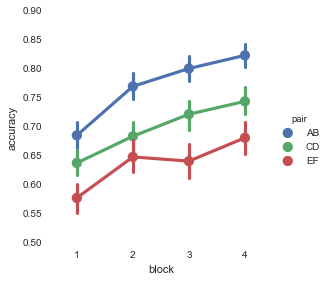

In [53]:
# For the paper, I think it would be great to have all the data from these studies in one panel, with separate 
# panels for RMD controls and MDDs. Since there is little variation by Experiment here, I'm going to average over
# Experiment and just plot Pair x Block to use space efficiently.

sns.factorplot(y='accuracy',x='block',hue='pair',hue_order=['AB','CD','EF'],
               units='ID',ci=68,data=train)
sns.plt.savefig(path2figs + 'PST_RM123_AsOne_TrainAcc.pdf')

### Training RT

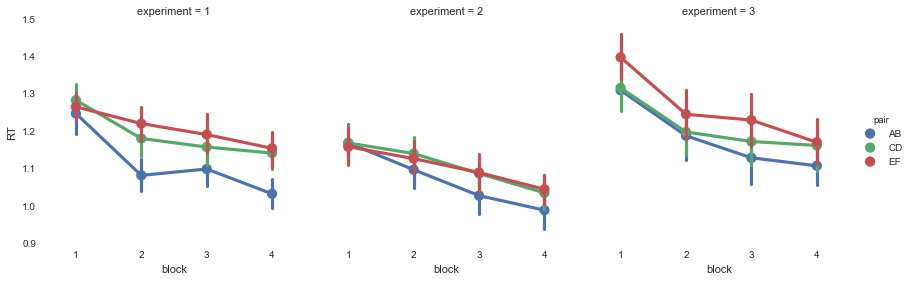

In [54]:
sns.factorplot(y='RT',x='block',hue='pair',hue_order=['AB','CD','EF'],units='ID',ci=68,col='experiment',data=train)
sns.plt.savefig(path2figs + 'PST_RM123_TrainRT.pdf')

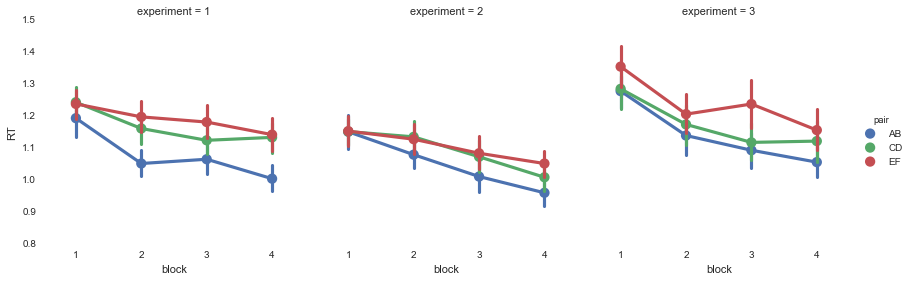

In [55]:
# Correct RT
sns.factorplot(y='RT',x='block',hue='pair',hue_order=['AB','CD','EF'],units='ID',ci=68,col='experiment',
               data=train[train.accuracy == 1])
sns.plt.savefig(path2figs + 'PST_RM123_TrainCorrRT.pdf')

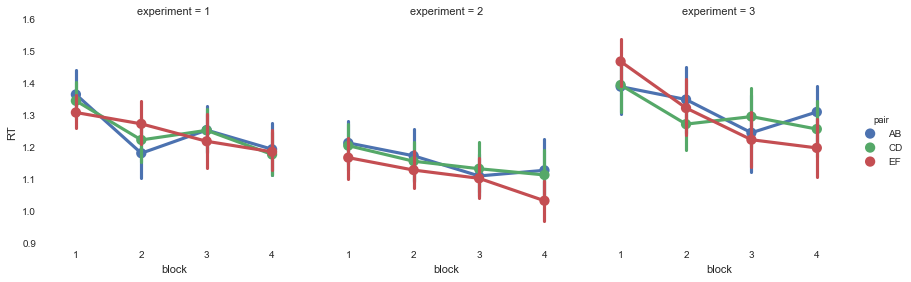

In [56]:
# Error RT . . . RT on AB pairs clearly pulls away more for correct (above) vs. error RTs
sns.factorplot(y='RT',x='block',hue='pair',hue_order=['AB','CD','EF'],units='ID',ci=68,col='experiment',
               data=train[train.accuracy == 0])
sns.plt.savefig(path2figs + 'PST_RM123_TrainCorrRT.pdf')

In [57]:
%R train$accuracy <- as.factor(train$accuracy)
%R train_rt.aov <- aov_ez(id='ID',dv='lnRT',within=c('pair','block','accuracy'),between='experiment',\
                          anova_table=list(correction='GG',es='pes'),data=train)
%R print(train_rt.aov) # Effects of Pair, Block, Accuracy

Anova Table (Type 3 tests)

Response: lnRT
                           Effect           df  MSE         F  pes p.value
1                      experiment        2, 43 1.27      0.64  .03     .53
2                            pair  1.91, 81.96 0.04    4.29 *  .09     .02
3                 experiment:pair  3.81, 81.96 0.04      0.85  .04     .49
4                           block  1.99, 85.66 0.19    3.01 +  .07     .05
5                experiment:block  3.98, 85.66 0.19      0.49  .02     .74
6                        accuracy        1, 43 0.03 15.09 ***  .26   .0003
7             experiment:accuracy        2, 43 0.03      1.86  .08     .17
8                      pair:block 4.93, 212.12 0.02      0.75  .02     .58
9           experiment:pair:block 9.87, 212.12 0.02      1.12  .05     .35
10                  pair:accuracy  1.95, 83.69 0.03      1.45  .03     .24
11       experiment:pair:accuracy  3.89, 83.69 0.03      0.86  .04     .49
12                 block:accuracy 2.85, 122.44 0.02      

In [58]:
# Following up the Pair effect . . . 
%R train_rt_pair.lsm <- lsmeans(train_rt.aov, ~pair)
%R print(train_rt_pair.lsm)
%R print(pairs(train_rt_pair.lsm),adjust='none') # Only AB vs. EF is significantly different

 pair     lsmean         SE    df   lower.CL  upper.CL
 AB   0.08863137 0.02310332 82.11 0.04267242 0.1345903
 CD   0.10947434 0.02297542 80.41 0.06375535 0.1551933
 EF   0.12541917 0.02298093 80.48 0.07968985 0.1711485

Results are averaged over the levels of: experiment, block, accuracy 
Confidence level used: 0.95 


 contrast    estimate         SE  df t.ratio p.value
 AB - CD  -0.02084297 0.01365853 164  -1.526  0.1289
 AB - EF  -0.03678780 0.01368632 164  -2.688  0.0079
 CD - EF  -0.01594483 0.01302441 164  -1.224  0.2226

Results are averaged over the levels of: experiment, block, accuracy 


In [59]:
# Follow-up Block effect
%R train_rt_block.lsm <- lsmeans(train_rt.aov, ~ block)
%R print(train_rt_block.lsm) # Looks like the RT difference grows as the blocks progress, but big jump is 1 to 2
%R print(pairs(train_rt_block.lsm)) # RT is faster in 3|4 vs. 1, no other differences

 block     lsmean         SE     df   lower.CL  upper.CL
 X1    0.15977036 0.02603584 127.32 0.10825137 0.2112893
 X2    0.11629492 0.02674791 139.33 0.06341066 0.1691792
 X3    0.07884058 0.02647884 134.76 0.02647274 0.1312084
 X4    0.07646064 0.02668455 138.25 0.02369803 0.1292232

Results are averaged over the levels of: experiment, pair, accuracy 
Confidence level used: 0.95 


 contrast    estimate         SE  df t.ratio p.value
 X1 - X2  0.043475435 0.02448239 264   1.776  0.2873
 X1 - X3  0.080929785 0.02377709 264   3.404  0.0043
 X1 - X4  0.083309723 0.02443353 264   3.410  0.0042
 X2 - X3  0.037454350 0.02550090 264   1.469  0.4579
 X2 - X4  0.039834288 0.02573703 264   1.548  0.4106
 X3 - X4  0.002379938 0.02528130 264   0.094  0.9997

Results are averaged over the levels of: experiment, pair, accuracy 
P value adjustment: tukey method for comparing a family of 4 estimates 


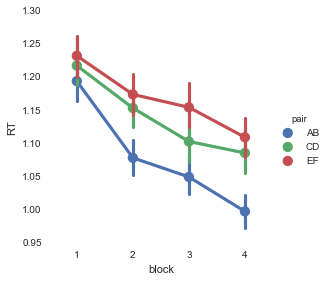

In [60]:
# Again plotting with data averaged over Experiment . . . just plotting correct RTs here for clarity
sns.factorplot(y='RT',x='block',hue='pair',hue_order=['AB','CD','EF'],units='ID',ci=68,data=train[train.accuracy == 1])
sns.plt.savefig(path2figs + 'PST_RM123_AsOne_TrainCorrRT.pdf')

### Win-stay/lose-shift

In [61]:
def WinStayCheck(df):
    '''For each pair, check on subject's last choice and feedback. If the last feedback was a reward and the subject
    sticks with the same choice, that's a win-stay trial. If the last feedback was a reward and subject changes choice,
    that's a win-shift trial. If the last feedback was a zero and the subject choice stays/shifts, that's lose-stay/
    lose-shift. Assumes the df has a column "ID".'''
    
    dfs = []
    for sub in df.ID.unique():
        
        d = {'AB':{'last_choice':'none','last_feedback':'none'},
             'CD':{'last_choice':'none','last_feedback':'none'},
             'EF':{'last_choice':'none','last_feedback':'none'}}
        
        sdf = df[df.ID == sub]
        tt = []
        for i, row_i in sdf.iterrows():
            if d[row_i.pair]['last_choice'] == 'none':
                tt.append(np.nan)

            elif (d[row_i.pair]['last_choice'] == row_i.choice) and (d[row_i.pair]['last_feedback'] == 'reward'):
                tt.append('win-stay')
            
            elif (d[row_i.pair]['last_choice'] != row_i.choice) and (d[row_i.pair]['last_feedback'] == 'reward'):
                tt.append('win-shift')
            
            elif (d[row_i.pair]['last_choice'] == row_i.choice) and (d[row_i.pair]['last_feedback'] == 'zero'):
                tt.append('lose-stay')
            
            elif (d[row_i.pair]['last_choice'] != row_i.choice) and (d[row_i.pair]['last_feedback'] == 'zero'):
                tt.append('lose-shift')

            d[row_i.pair]['last_choice'] = row_i.choice
            d[row_i.pair]['last_feedback'] = row_i.feedback
        
        sdf['trial_type'] = tt
    
        dfs.append(sdf)
    out = pd.concat(dfs)
    out.reset_index(inplace=True,drop=True)
    
    return out

In [62]:
train.head()

,experiment,subject,ID,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,feedback,lnRT,outlier,choice,pair
0,1,1,1_1,1,1,4,3,right,1.177,1,zero,0.162969,0,E,EF
1,1,1,1_1,1,2,6,1,left,1.388,0,zero,0.327864,0,B,AB
2,1,1,1_1,1,3,2,5,right,1.346,0,zero,0.297137,0,D,CD
3,1,1,1_1,1,4,3,4,right,1.488,0,zero,0.397433,0,F,EF
4,1,1,1_1,1,5,6,1,right,1.455,1,reward,0.375006,0,A,AB


In [63]:
# Looks right
train = WinStayCheck(train)
train.head(20)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,experiment,subject,ID,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,feedback,lnRT,outlier,choice,pair,trial_type
0,1,1,1_1,1,1,4,3,right,1.177,1,zero,0.162969,0,E,EF,NaN
1,1,1,1_1,1,2,6,1,left,1.388,0,zero,0.327864,0,B,AB,NaN
2,1,1,1_1,1,3,2,5,right,1.346,0,zero,0.297137,0,D,CD,NaN
3,1,1,1_1,1,4,3,4,right,1.488,0,zero,0.397433,0,F,EF,lose-shift
4,1,1,1_1,1,5,6,1,right,1.455,1,reward,0.375006,0,A,AB,lose-shift
5,1,1,1_1,1,6,5,2,left,1.654,0,zero,0.503197,0,D,CD,lose-stay
6,1,1,1_1,1,7,3,4,right,1.296,0,reward,0.259283,0,F,EF,lose-stay
7,1,1,1_1,1,8,5,2,right,1.096,1,zero,0.091667,0,C,CD,lose-shift
8,1,1,1_1,1,9,6,1,right,0.855,1,reward,-0.156654,0,A,AB,win-stay
9,1,1,1_1,1,10,5,2,right,0.963,1,reward,-0.037702,0,C,CD,lose-stay


In [64]:
df.head()

,block,trial_num,left_stim,left_stim_number,right_stim,right_stim_number,object_onset,object_duration,response,response_onset,...,isi_duration,scheduled_outcome,feedback,feedback_onset,feedback_duration,iti_onset,iti_duration,subject,experiment,ID
0,1,1,Stimuli/6.bmp,3,Stimuli/4.bmp,4,14.993,3.039,left,15.611,...,0.501,1,reward,18.533,1.406,19.939,7.551,22,3,3_22
1,1,2,Stimuli/2.bmp,1,Stimuli/3.bmp,6,27.490,3.035,right,28.622,...,0.506,1,zero,31.031,1.219,32.250,0.234,22,3,3_22
2,1,3,Stimuli/5.bmp,2,Stimuli/1.bmp,5,32.484,3.035,left,33.636,...,2.009,1,reward,37.528,1.035,38.563,0.427,22,3,3_22
3,1,4,Stimuli/4.bmp,4,Stimuli/6.bmp,3,38.991,3.029,right,40.783,...,1.997,0,zero,44.018,1.004,45.022,0.472,22,3,3_22
4,1,5,Stimuli/2.bmp,1,Stimuli/3.bmp,6,45.495,3.039,left,46.745,...,3.006,0,zero,51.541,1.019,52.559,1.949,22,3,3_22


In [65]:
# Now how about a graph of the evolution of win-stay trials as a function of pair type and block number?
# First need to do some legwork . . . 

g = train.groupby(['experiment','subject','ID','block','pair'])['trial_type'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
new_cols = ['experiment','subject','ID','block','pair', 'trial_type','count']
df.columns = new_cols
df.head()

# Now compute percentages
d = {}
for sub in df.ID.unique():
    for curr_block in range(1,5):
        for curr_pair in ['AB','CD','EF']:
            count_sum = df[(df.ID == sub) & (df.block == curr_block) & (df.pair == curr_pair)]['count'].sum()
            d[(sub,curr_block,curr_pair)] = count_sum #

# I'm sure there is a better way, but this works . . . 
pcts = []
for i, row_i in df.iterrows():
    count_sum = d[(row_i.ID,row_i.block,row_i.pair)]
    pct = float(row_i['count'])/count_sum
    pcts.append(pct)
df['pct'] = pcts

In [66]:
# Looks right
df.head()

,experiment,subject,ID,block,pair,trial_type,count,pct
0,1,1,1_1,1,AB,win-stay,12,0.631579
1,1,1,1_1,1,AB,lose-stay,4,0.210526
2,1,1,1_1,1,AB,lose-shift,2,0.105263
3,1,1,1_1,1,AB,win-shift,1,0.052632
4,1,1,1_1,1,CD,win-stay,7,0.388889


In [67]:
# Also looks right
df.tail()

,experiment,subject,ID,block,pair,trial_type,count,pct
4450,3,9,3_9,4,CD,win-shift,1,0.05
4451,3,9,3_9,4,EF,win-stay,10,0.50
4452,3,9,3_9,4,EF,lose-stay,4,0.20
4453,3,9,3_9,4,EF,lose-shift,3,0.15
4454,3,9,3_9,4,EF,win-shift,3,0.15


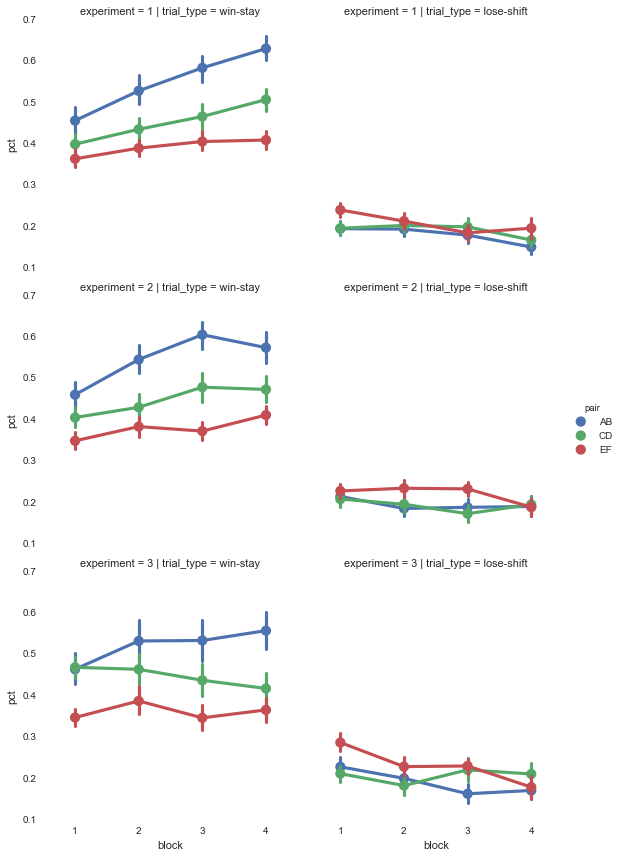

In [68]:
# Okay, now graph of the evolution of the percentage of win-stay trials as a function of pair type and block number.
# Really only need win-stay and lose-shift--the other bins are complementary, and these are the key ones
sns.factorplot(y='pct',x='block',hue='pair',col='trial_type',row='experiment',units='subject',ci=68,
               data=df[((df.trial_type == 'win-stay') | (df.trial_type == 'lose-shift'))])

In [69]:
# Okay, run the ANOVA . . . Pair x TT interaction
ws = df[(df.trial_type == 'win-stay') | (df.trial_type == 'lose-shift')]

%Rpush ws
%R ws$experiment <- as.factor(ws$experiment)
%R ws$block <- as.factor(ws$block)
%R str(ws)

%R ws.aov <- aov_ez(id='ID',dv='pct',within=c('block','pair','trial_type'),between='experiment',data=ws,\
                   anova_table=list(correction='GG',es='pes'))
%R print(ws.aov)

'data.frame':	2286 obs. of  8 variables:
 $ experiment: Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ subject   : Factor w/ 54 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ID        : Factor w/ 105 levels "1_1","1_10","1_11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ block     : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 2 2 2 3 ...
 $ pair      : Factor w/ 3 levels "AB","CD","EF": 1 1 2 2 3 3 1 2 3 1 ...
 $ trial_type: Factor w/ 2 levels "lose-shift","win-stay": 2 1 2 1 2 1 2 2 2 2 ...
 $ count     : int  12 2 7 4 8 2 16 14 13 17 ...
 $ pct       : num  0.632 0.105 0.389 0.222 0.421 ...


Anova Table (Type 3 tests)

Response: pct
                             Effect           df  MSE         F  pes p.value
1                        experiment        2, 35 0.04      0.52  .03     .60
2                             block  2.80, 97.99 0.01      0.91  .03     .43
3                  experiment:block  5.60, 97.99 0.01      0.98  .05     .44
4                              pair  1.99, 69.68 0.01 14.92 ***  .30  <.0001
5                   experiment:pair  3.98, 69.68 0.01      0.15 .009     .96
6                        trial_type        1, 35 0.09 32.77 ***  .48  <.0001
7             experiment:trial_type        2, 35 0.09      0.06 .004     .94
8                        block:pair 4.94, 172.79 0.01      1.08  .03     .37
9             experiment:block:pair 9.87, 172.79 0.01      0.56  .03     .84
10                 block:trial_type 2.93, 102.41 0.02    2.18 +  .06     .10
11      experiment:block:trial_type 5.85, 102.41 0.02      0.88  .05     .51
12                  pair:trial_typ

In [70]:
# All pairwise comparisons are significant for win-stay (AB > CD > EF), none are significant for lose-shift
# (this reflects correction for the number of post-hocs . . . if that's turned off, you get more lose-shifts for EF
# than for any other pair).

%R ws.lsm <- lsmeans(ws.aov, ~ pair*trial_type)
%R print(ws.lsm)
%R print(pairs(ws.lsm))

 pair trial_type    lsmean         SE     df  lower.CL  upper.CL
 AB   lose.shift 0.2522229 0.01267179 198.08 0.2272340 0.2772118
 CD   lose.shift 0.2575159 0.01250562 190.27 0.2328484 0.2821833
 EF   lose.shift 0.2830532 0.01242164 186.29 0.2585480 0.3075584
 AB   win.stay   0.4839893 0.01267179 198.08 0.4590004 0.5089783
 CD   win.stay   0.4175761 0.01250562 190.27 0.3929087 0.4422436
 EF   win.stay   0.3610304 0.01242164 186.29 0.3365252 0.3855356

Results are averaged over the levels of: experiment, block 
Confidence level used: 0.95 


 contrast                          estimate         SE     df t.ratio p.value
 AB,lose.shift - CD,lose.shift -0.005292957 0.01332985 304.94  -0.397  0.9987
 AB,lose.shift - EF,lose.shift -0.030830285 0.01309216 304.66  -2.355  0.1758
 AB,lose.shift - AB,win.stay   -0.231766430 0.02294167 136.93 -10.102  <.0001
 AB,lose.shift - CD,win.stay   -0.165353219 0.02120907 107.04  -7.796  <.0001
 AB,lose.shift - EF,win.stay   -0.108807492 0.02119501 106.79  -5.134  <.0001
 CD,lose.shift - EF,lose.shift -0.025537328 0.01260372 305.92  -2.026  0.3299
 CD,lose.shift - AB,win.stay   -0.226473473 0.02120907 107.04 -10.678  <.0001
 CD,lose.shift - CD,win.stay   -0.160060262 0.02267051 132.03  -7.060  <.0001
 CD,lose.shift - EF,win.stay   -0.103514534 0.02119070 106.74  -4.885  0.0001
 EF,lose.shift - AB,win.stay   -0.200936145 0.02119501 106.79  -9.480  <.0001
 EF,lose.shift - CD,win.stay   -0.134522934 0.02119070 106.74  -6.348  <.0001
 EF,lose.shift - EF,win.stay   -0.077977206 0.02254481 129.76  -

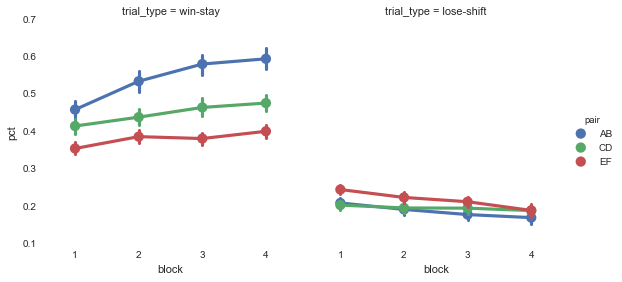

In [71]:
# Now graph of the evolution of the percentage of win-stay/lose-shift trials by pair type and block number . . . 
# . . . averaged over Experiment.
sns.factorplot(y='pct',x='block',hue='pair',col='trial_type',units='subject',ci=68,
               data=df[((df.trial_type == 'win-stay') | (df.trial_type == 'lose-shift'))])

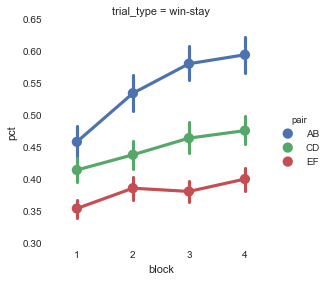

In [72]:
# Just win-stay
sns.factorplot(y='pct',x='block',hue='pair',col='trial_type',units='subject',ci=68,
               data=df[df.trial_type == 'win-stay'])

## Assemble and analyze the PST ratings data . . . 

In [73]:
dfs = []
for e_path in [path2d1,path2d2,path2d3]:
    rate_d = re.compile('[\w]+_PST[\D]+ratings.csv')
    for path, directory, files in os.walk(e_path):
        for fname in files:
            rate_m = rate_d.search(fname)
            if rate_m:
                curr_file = path + '/' + fname
                df = pd.read_csv(curr_file)
                if e_path == path2d3:
                    new_cols = ['outcome','prompt','rating']
                    df.columns = new_cols
                    df['experiment'] = 3
                elif e_path == path2d1:
                    new_cols = ['outcome','prompt','rating']
                    df.columns = new_cols
                    df['experiment'] = 1
                elif e_path == path2d2:
                    new_cols = ['outcome','prompt','rating']
                    df.columns = new_cols
                    df['experiment'] = 2
                sub = fname.split('_')[0]
                sub = sub.lstrip('0')
                df['subject'] = sub
                df['ID'] = df.experiment.astype(str) + '_' + df.subject.astype(str)
                dfs.append(df)
rate = pd.concat(dfs)
new_cols = ['outcome', 'prompt', 'old_rating', 'experiment', 'subject', 'ID']
rate.columns = new_cols
rate['rating'] = rate['old_rating'] + 1
rate.reset_index(inplace=True,drop=True)
rate = rate[['experiment','subject','ID','prompt','outcome','rating']]
rate = rate[~(rate.ID.isin(asleep))]
rate.head()                

,experiment,subject,ID,prompt,outcome,rating
0,1,1,1_1,valence,reward,5
1,1,1,1_1,valence,zero,2
2,1,1,1_1,arousal,reward,5
3,1,1,1_1,arousal,zero,1
4,1,2,1_2,valence,reward,3


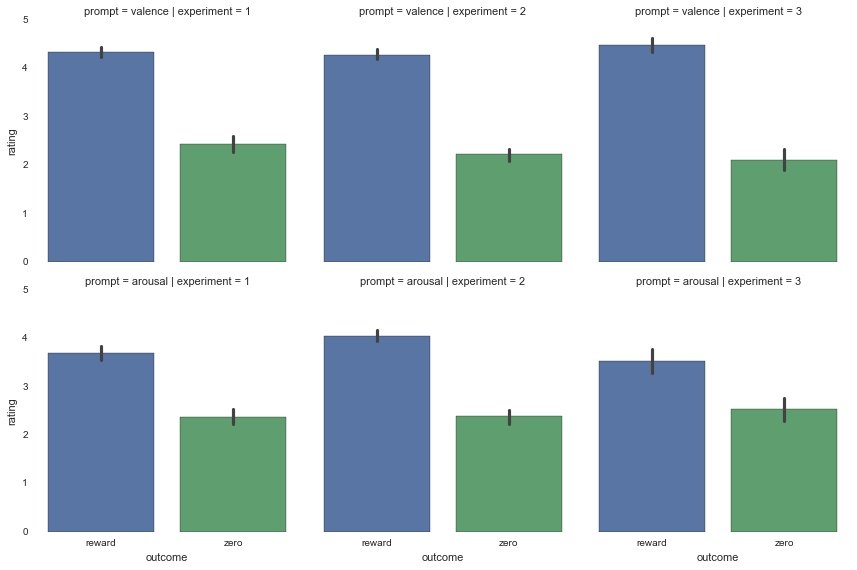

In [74]:
sns.factorplot(y='rating',x='outcome',col='experiment',row='prompt',kind='bar',units='ID',ci=68,data=rate)
sns.plt.savefig(path2figs + 'PST_RM123_Ratings.pdf')

In [75]:
%Rpush rate
# %R str(rate)
%R rate$experiment <- as.factor(rate$experiment)

%R valence <- subset(rate, prompt == 'valence')
%R arousal <- subset(rate, prompt == 'arousal')

%R valence.aov <- aov_ez(id='ID',dv='rating',within='outcome',between='experiment',data=valence,\
                        anova_table=list(correction='GG',es='pes'))
%R print(valence.aov) # Valence, main effect of Outcome, nothing else

%R arousal.aov <- aov_ez(id='ID',dv='rating',within='outcome',between='experiment',data=arousal,\
                        anova_table=list(correction='GG',es='pes'))
%R print(arousal.aov) # Arousal, main effect of Outcome, nothing else

print rate.groupby(['prompt','outcome'])['rating'].mean()
print rate.groupby(['prompt','outcome'])['rating'].std()

Anova Table (Type 3 tests)

Response: rating
              Effect     df  MSE          F  pes p.value
1         experiment 2, 122 0.88       0.51 .008     .60
2            outcome 1, 122 0.88 266.35 ***  .69  <.0001
3 experiment:outcome 2, 122 0.88       0.97  .02     .38

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: rating
              Effect     df  MSE         F pes p.value
1         experiment 2, 122 1.17      0.86 .01     .43
2            outcome 1, 122 1.11 82.61 *** .40  <.0001
3 experiment:outcome 2, 122 1.11      1.61 .03     .20

Sphericity correction method: GG 


prompt   outcome
arousal  reward     3.800
         zero       2.400
valence  reward     4.336
         zero       2.288
Name: rating, dtype: float64
prompt   outcome
arousal  reward     1.031754
         zero       1.107161
valence  reward     0.782304
         zero       1.068735
Name: rating, dtype: float64


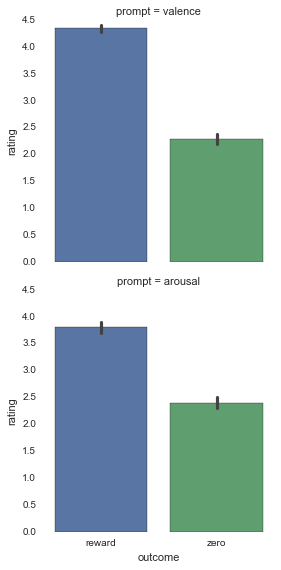

In [76]:
# Collapsed over experiment . . . 
sns.factorplot(y='rating',x='outcome',row='prompt',kind='bar',units='ID',ci=68,data=rate)
sns.plt.savefig(path2figs + 'PST_RM123_AsOne_Ratings.pdf')

## Test data 

In addition to the usual ANOVAs on Choose A vs. Avoid B and W/W vs. W/L vs. L/L, run lmers with 'reward discrepancy' and training accuracy (AB,CD,EF) as predictors . . . when done with this, aggregate everything for individual diffs. Then maybe (a) add modeling and (b) repeat this exercise with RevMem to make your life easier when you're writing this up.

In [77]:
test_d = re.compile('[\w]+test.csv$')

# Assemble data
dfs = []
for e_path in [path2d1,path2d2,path2d3]:
    
    for path, directory, files in os.walk(e_path):
        for fname in files:
            test_m = test_d.search(fname)
            if test_m:
                sub = fname.split('_')[0]
                sub = sub.lstrip('0')
                curr_file = path + '/' + fname
                df = pd.read_csv(curr_file)
                new_cols = ['block','trial','left_stim_number','right_stim_number','response','RT','accuracy']
                if e_path == path2d1:
                    new_cols = ['block','trial','left_stim_number','right_stim_number','response','RT','accuracy']
                    df.columns = new_cols
                    df['experiment'] = 1
                elif e_path == path2d2:
                    df.columns = new_cols
                    df['experiment'] = 2
                elif e_path == path2d3:
                    df = df[['block_id','trial_id','left_stim_number','right_stim_number','response',
                             'trial_RT','trial_accuracy']]
                    df.columns = new_cols
                    df['experiment'] = 3
                df['subject'] = sub
                df['ID'] = df.experiment.astype(str) + '_' + df.subject.astype(str)
                dfs.append(df)

test = pd.concat(dfs)
test = test[~(test.subject == 'JMPilot')]
test.reset_index(inplace=True,drop=True)

# Add lnRT, mark trials with raw RT < 100 ms or lnRT > mean+/-3SDs as outliers
test['lnRT'] = test.RT.apply(np.log)
test = OutCheck(test)

# First count and drop trials with no response
all_trials = len(test)
test = test.dropna(subset=['outlier'])
no_nulls = len(test)
num_nr = all_trials - no_nulls
pct_nr = 100*(float(num_nr)/all_trials)

print 'There were ' + str(all_trials) + ' test trials total, collapsing over all participants and experiments.'
print '\nThere were ' + str(num_nr) + ' test trials with no response.\n\
That is ' + '{:.3f}'.format(pct_nr) + '% of the trials. Those trials have been dropped.'

# Now count and drop outliers
num_outs = len(test[test.outlier == 1])
pct_outs = 100*(float(num_outs)/len(test))
test = test[~(test.outlier == 1)]

print '\nThere were ' + str(num_outs) + ' outliers during the test phase.\n\
That is ' + '{:.3f}'.format(pct_outs) + '% of the trials. Those trials have been dropped.'

print 'That leaves ' + str(len(test)) + ' trials.'

# Adding pair, the difference/discrepany b/w stimuli in reinforcement rate, and the participant's choice
def AddPairDisChoice(data):
    '''Given the left and right stim numbers, plus the subject's response, add the stimulus pair, 
    the discrepancy b/w reward probabilities for the stimuli, and the participant's choice.'''
    
    left_stim_number, right_stim_number, response = data
    choice = np.nan
    discrepancy = np.nan
    pair = np.nan
    
    stims = {1:('A',80),2:('C',70),3:('E',60),4:('F',40),5:('D',30),6:('B',20)}
    
    pair = stims[left_stim_number][0] + stims[right_stim_number][0]
    discrepancy = np.abs(stims[left_stim_number][1] - stims[right_stim_number][1])
    
    if response == 'left':
        choice = stims[left_stim_number][0]
    elif response == 'right':
        choice = stims[right_stim_number][0]
    
    return (pair,discrepancy,choice)

test['pair'],test['difference'],test['choice']= zip(*test[['left_stim_number','right_stim_number',
                                                            'response']].apply(AddPairDisChoice,axis=1))

# Add Choose A vs. Avoid B, also add W/W, W/L, L/L status
def CodeTypes(pair):
    '''Given the pair presented, code the trial type as (a) Choose A, Avoid B, or neither, and
    the conflict trial type as (b) "win/win" (WW), "win/lose" (WL), or "lose/lose" (LL).'''
    
    tt = np.nan
    ct = np.nan
    
    # Trial type first 
    if ('AB' in pair) or ('BA' in pair):
        tt = 'neither'
    elif 'A' in pair:
        tt = 'ChooseA'
    elif 'B' in pair:
        tt = 'AvoidB'
    else:
        tt = 'neither'
    
    # Conflict trial type next, so called b/c conflict higher on WW and LL than WL
    trained = ['AB','BA','CD','DC','EF','FE']
    ww = ['AC','CA','AE','EA','CE','EC']
    ll = ['BD','DB','BF','FB','DF','FD']
    wl = ['AD','DA','AF','FA','CB','BC','CF','FC','EB','BE','ED','DE']
    
    if pair in trained:
        ct = 'trained'
    elif pair in ww:
        ct = 'WW'
    elif pair in ll:
        ct = 'LL'
    elif pair in wl:
        ct = 'WL'
    else:
        print "pair = " + pair + "; I don't recognize that pair, stopping!"
        ct = 'none'
    
    return (tt,ct)

test['trial_type'],test['con_trial_type'] = zip(*test.pair.apply(CodeTypes))


# Now take only those subjects w/o neurological problems, not using psychotropics, and not asleep during training.
test = test[(test.ID.isin(NoMeds.ID.unique()))]
test = test[~(test.ID.isin(asleep))]
print '\nThe number of "clean" subjects with test data is ' + str(test.ID.nunique()) + '.'
print 'With just those subjects, we have ' + str(len(test)) + ' test trials.\n'

print test.groupby('experiment')['ID'].nunique()

test.reset_index(inplace=True,drop=True)
test.head()    

There were 22680 test trials total, collapsing over all participants and experiments.

There were 135 test trials with no response.
That is 0.595% of the trials. Those trials have been dropped.

There were 57 outliers during the test phase.
That is 0.253% of the trials. Those trials have been dropped.
That leaves 22488 trials.

The number of "clean" subjects with test data is 105.
With just those subjects, we have 18752 test trials.

experiment
1    46
2    38
3    21
Name: ID, dtype: int64


/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,experiment,subject,ID,lnRT,outlier,pair,difference,choice,trial_type,con_trial_type
0,1,1,6,4,right,2.296,1,1,1,1_1,0.831168,0,BF,20,F,AvoidB,LL
1,1,2,2,4,left,2.455,1,1,1,1_1,0.898127,0,CF,30,C,neither,WL
2,1,3,3,2,left,2.479,0,1,1,1_1,0.907855,0,EC,10,E,neither,WW
3,1,4,1,5,left,0.522,1,1,1,1_1,-0.650088,0,AD,50,A,ChooseA,WL
4,1,5,1,4,left,0.663,1,1,1,1_1,-0.410980,0,AF,40,A,ChooseA,WL


In [78]:
# Important: screen out everyone with < 50% accuracy on AB test trials
df = misc.MakeFrame(in_df=test[(test.pair == 'AB') | (test.pair == 'BA')],id_vars=['ID','experiment'],dv='accuracy')
df.head()

# 3 subjects from Exp 1, 3 from Exp 2, and 2 from Exp 3 will be excluded based on this
ab_test_fail = []
for i, row_i in df.iterrows():
    if row_i.accuracy <= 0.501:
        print row_i.ID
        ab_test_fail.append(row_i.ID)
test = test[~(test.ID.isin(ab_test_fail))]

1_28
1_31
1_34
2_22
2_41
2_49
3_13


Anova Table (Type 3 tests)

Response: accuracy
                 Effect    df  MSE    F pes p.value
1            experiment 2, 95 0.05 1.24 .03     .29
2            trial_type 1, 95 0.04 0.99 .01     .32
3 experiment:trial_type 2, 95 0.04 0.50 .01     .61

Sphericity correction method: GG 


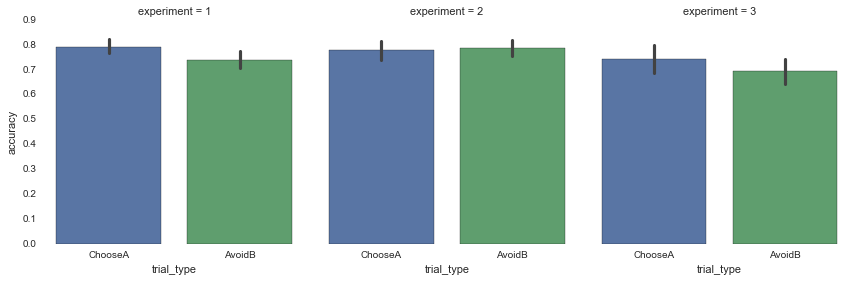

In [79]:
# Okay, let's look at Choose A vs. Avoid B accuracy first. Inconsistent effect, no significant effects in ANOVA.

ab = test[(test.trial_type == 'ChooseA') | (test.trial_type == 'AvoidB')]
sns.factorplot(y='accuracy',x='trial_type',order=['ChooseA','AvoidB'],units='subject',col='experiment',
               kind='bar',ci=68,data=ab)

%Rpush ab
# %R str(ab)
%R ab$experiment <- as.factor(ab$experiment)

%R ab_acc.aov <- aov_ez(id='ID',dv='accuracy',within='trial_type',between='experiment',\
                        anova_table=list(correction='GG',es='pes'), data=ab)
%R print(ab_acc.aov)

In [80]:
df = misc.MakeFrame(in_df=ab,id_vars=['ID','experiment','trial_type','accuracy'],dv=['lnRT','RT'],agg_func='mean')
df.head()

,ID,experiment,trial_type,accuracy,lnRT,RT
0,1_1,1,AvoidB,0,-0.316539,0.738000
1,1_1,1,AvoidB,1,-0.108110,0.936717
2,1_1,1,ChooseA,1,-0.514646,0.613042
3,1_10,1,AvoidB,0,0.900592,2.568235
4,1_10,1,AvoidB,1,0.642562,1.969429


In [81]:
# 20 subjects don't have data in at least one bin, I think typically ChooseA error . . . 
# . . . they need to be dropped for the trial_type comparison on error trials to work
miss_bins = []
for sub in df.ID.unique():
    sdf = df[df.ID == sub]
    if len(sdf) < 4:
        miss_bins.append(sub)
print len(miss_bins)

20


In [82]:
# Effect of trial type on RT whether or not you're right or wrong . . . Choose A faster than Avoid B
bal = df[~(df.ID.isin(miss_bins))] # 'bal(anced)' b/c all cells have data
corr = bal[bal.accuracy == 1]
err = bal[bal.accuracy == 0]

misc.ttest_2s(corr[corr.trial_type == 'ChooseA']['lnRT'],corr[corr.trial_type == 'AvoidB']['lnRT'],paired=True)
misc.ttest_2s(err[err.trial_type == 'ChooseA']['lnRT'],err[err.trial_type == 'AvoidB']['lnRT'],paired=True)

t(77) = -2.01, p = 0.048, g = -0.228
t(77) = -3.82, p = 0.000, g = -0.438


(-3.8240413900239689, 0.00026492934477375041, -0.43786645465748403)

Anova Table (Type 3 tests)

Response: lnRT
                          Effect    df  MSE         F  pes p.value
1                     experiment 2, 75 0.29      1.40  .04     .25
2                     trial_type 1, 75 0.05 11.76 ***  .14   .0010
3          experiment:trial_type 2, 75 0.05      0.42  .01     .66
4                       accuracy 1, 75 0.02 30.98 ***  .29  <.0001
5            experiment:accuracy 2, 75 0.02    2.72 +  .07     .07
6            trial_type:accuracy 1, 75 0.03    6.12 *  .08     .02
7 experiment:trial_type:accuracy 2, 75 0.03      0.26 .007     .77

Sphericity correction method: GG 


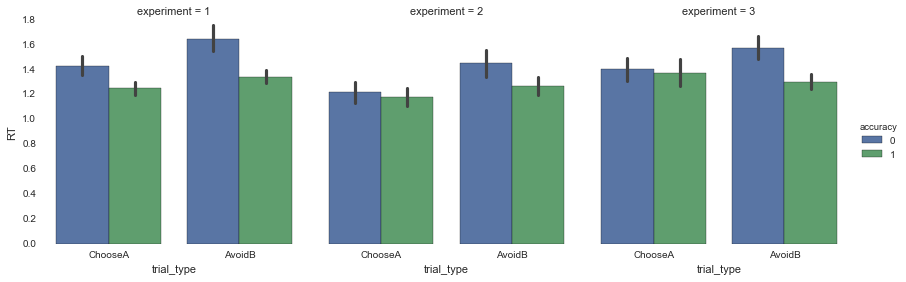

In [83]:
# Now RT, this time using the 'bal' data as that has the 85 subjects with data in all cells.
# Effects of Trial Type (Ch A < Av B), accuracy (right < wrong), and a TT x Acc interaction: obviously accuracy
# matters more for RT on Avoid B trials.

sns.factorplot(y='RT',x='trial_type',hue='accuracy',order=['ChooseA','AvoidB'],units='ID',col='experiment',
               kind='bar',ci=68,data=bal)

%Rpush bal
%R bal$experiment <- as.factor(bal$experiment)

%R ab_rt.aov <- aov_ez(id='ID',dv='lnRT',within=c('trial_type','accuracy'),between='experiment',\
                        anova_table=list(correction='GG',es='pes'), data=bal)
%R print(ab_rt.aov)

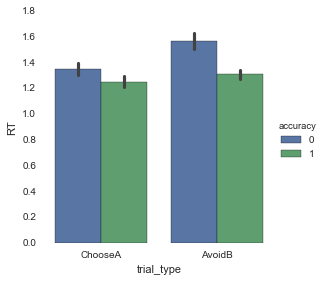

In [84]:
# Trial Type x Accuracy . . . looks like the effect is driven primarily by error trials.
sns.factorplot(y='RT',x='trial_type',hue='accuracy',order=['ChooseA','AvoidB'],units='ID',
               kind='bar',ci=68,data=bal)

In [85]:
# Follow-up the interaction . . . yup, Choose A < Avoid B on error but not correct trials.
# I'm not sure why there is no TT effect on correct trials as I got one above with the t-test . . . maybe it's
# just the inclusion of experiment and accuracy as factors, rather than collapsing over experiment and running the
# tests at each level of accuracy separately (but lsmeans does the latter) . . . not sure.

%R ab_rt.lsm <- lsmeans(ab_rt.aov, ~trial_type*accuracy)
%R print(ab_rt.lsm)
%R print(pairs(ab_rt.lsm),adjust='none')

 trial_type accuracy    lsmean         SE     df   lower.CL  upper.CL
 AvoidB     X0       0.3361724 0.03628899 141.82 0.26443520 0.4079097
 ChooseA    X0       0.1892489 0.03628899 141.82 0.11751168 0.2609862
 AvoidB     X1       0.1788616 0.03628899 141.82 0.10712431 0.2505988
 ChooseA    X1       0.1407214 0.03628899 141.82 0.06898419 0.2124587

Results are averaged over the levels of: experiment 
Confidence level used: 0.95 


 contrast                  estimate         SE     df t.ratio p.value
 AvoidB,X0 - ChooseA,X0  0.14692352 0.03481094 144.13   4.221  <.0001
 AvoidB,X0 - AvoidB,X1   0.15731089 0.02873384 145.71   5.475  <.0001
 AvoidB,X0 - ChooseA,X1  0.19545101 0.03271218 132.72   5.975  <.0001
 ChooseA,X0 - AvoidB,X1  0.01038737 0.03271218 132.72   0.318  0.7513
 ChooseA,X0 - ChooseA,X1 0.04852749 0.02873384 145.71   1.689  0.0934
 AvoidB,X1 - ChooseA,X1  0.03814012 0.03481094 144.13   1.096  0.2751

Results are averaged over the levels of: experiment 


Correlation b/w Choose A minus Avoid B difference for accuracy and RT, r = -0.4906 p = 0.0000.


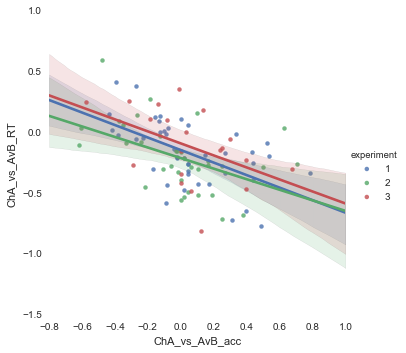

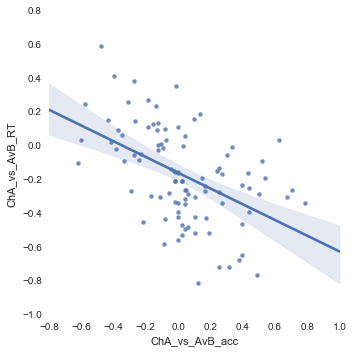

In [86]:
# Okay, now let's plot Choose A vs. Avoid B differences in accuracy vs. RT

df = misc.MakeFrame(in_df=ab, id_vars=['ID','experiment','trial_type'], dv=['accuracy','lnRT','RT'], agg_func='mean')
chA = df[df.trial_type == 'ChooseA']
avB = df[df.trial_type == 'AvoidB']
both = pd.merge(chA,avB,on='ID')
both = both[['ID','experiment_x','accuracy_x','lnRT_x','RT_x','accuracy_y','lnRT_y','RT_y']]
new_cols = ['ID','experiment','ChA_acc','ChA_lnRT','ChA_RT','AvB_acc','AvB_lnRT','AvB_RT']
both.columns = new_cols
both['ChA_vs_AvB_acc'] = both.ChA_acc - both.AvB_acc
both['ChA_vs_AvB_lnRT'] = both.ChA_lnRT - both.AvB_lnRT
both['ChA_vs_AvB_RT'] = both.ChA_RT - both.AvB_RT
both.head()

sns.lmplot(y='ChA_vs_AvB_RT',x='ChA_vs_AvB_acc',hue='experiment',units='ID',data=both)
sns.lmplot(y='ChA_vs_AvB_RT',x='ChA_vs_AvB_acc',units='ID',data=both)

r, p = sp.stats.pearsonr(both.ChA_vs_AvB_RT,both.ChA_vs_AvB_acc)
print 'Correlation b/w Choose A minus Avoid B difference for accuracy and RT, r = ' + '{:.4f}'.format(r) + \
' p = ' + '{:.4f}'.format(p) + '.'

Now onto the conflict trials . . . 

/Users/danieldillon/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Anova Table (Type 3 tests)

Response: accuracy
                     Effect           df  MSE         F  pes p.value
1                experiment        2, 95 0.05      0.31 .006     .74
2            con_trial_type 1.94, 184.15 0.05 28.14 ***  .23  <.0001
3 experiment:con_trial_type 3.88, 184.15 0.05      0.89  .02     .47

Sphericity correction method: GG 


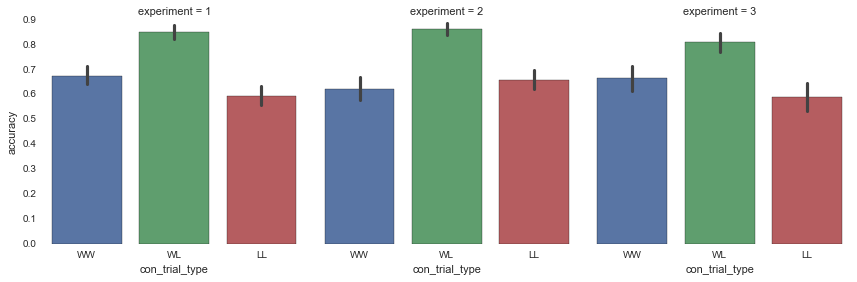

In [87]:
# Okay, look at accuracy first . . . WL clearly easiest, some evidence that LL harder than WW.
# ANOVA reveals a massive effect of Trial Type . . . 

con = test[~(test.con_trial_type == 'trained')]
con.con_trial_type = con.con_trial_type.astype(str)

sns.factorplot(y='accuracy',x='con_trial_type',order=['WW','WL','LL'],units='subject',col='experiment',
               kind='bar',ci=68,data=con)

%Rpush con
# %R str(test)
%R con$experiment <- as.factor(con$experiment)

%R con_acc.aov <- aov_ez(id='ID',dv='accuracy',within='con_trial_type',between='experiment',\
                        anova_table=list(correction='GG',es='pes'), data=con)
%R print(con_acc.aov)

In [88]:
# Indeed, WL > WW|LL, but WW = LL
%R con_acc.lsm <- lsmeans(con_acc.aov, ~con_trial_type)
%R print(con_acc.lsm)
%R print(pairs(con_acc.lsm),adjust='none')

 con_trial_type    lsmean         SE     df  lower.CL  upper.CL
 LL             0.6160098 0.02274227 284.96 0.5712456 0.6607739
 WL             0.8431045 0.02274227 284.96 0.7983404 0.8878687
 WW             0.6564278 0.02274227 284.96 0.6116637 0.7011920

Results are averaged over the levels of: experiment 
Confidence level used: 0.95 


 contrast    estimate         SE  df t.ratio p.value
 LL - WL  -0.22709479 0.03229416 190  -7.032  <.0001
 LL - WW  -0.04041808 0.03229416 190  -1.252  0.2123
 WL - WW   0.18667670 0.03229416 190   5.781  <.0001

Results are averaged over the levels of: experiment 


Finally, I want to try running lmer on the test data, with the difference in reinforcement rate and each participant's overall training accuracy as predictors . . . 

In [89]:
train_acc = misc.MakeFrame(in_df=train,id_vars='ID',dv='accuracy',agg_func='mean')
new_cols = ['ID','train_acc']
train_acc.columns = new_cols
train_acc.head()

,ID,train_acc
0,1_1,0.928870
1,1_10,0.763713
2,1_11,0.903766
3,1_12,0.786611
4,1_13,0.632911


In [90]:
test = pd.merge(test,train_acc,on='ID')
test.head()

,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,experiment,subject,ID,lnRT,outlier,pair,difference,choice,trial_type,con_trial_type,train_acc
0,1,1,6,4,right,2.296,1,1,1,1_1,0.831168,0,BF,20,F,AvoidB,LL,0.92887
1,1,2,2,4,left,2.455,1,1,1,1_1,0.898127,0,CF,30,C,neither,WL,0.92887
2,1,3,3,2,left,2.479,0,1,1,1_1,0.907855,0,EC,10,E,neither,WW,0.92887
3,1,4,1,5,left,0.522,1,1,1,1_1,-0.650088,0,AD,50,A,ChooseA,WL,0.92887
4,1,5,1,4,left,0.663,1,1,1,1_1,-0.410980,0,AF,40,A,ChooseA,WL,0.92887


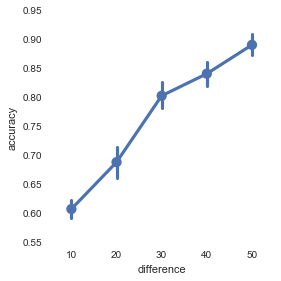

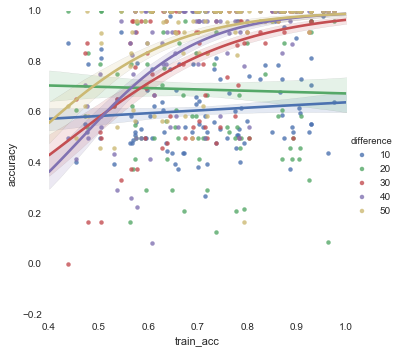

In [91]:
# The second plot is very cool, shows that the effect of discrepancy on accuracy interacts with training accuracy:
# the better you did during training, the more larger discrepancies matter to you at test . . . 

true_test = test[~(test.con_trial_type == 'trained')] # Drop the trained pairs
df = misc.MakeFrame(in_df=true_test,id_vars=['ID','difference','train_acc'],dv='accuracy',agg_func='mean')
df.head()

sns.factorplot(y='accuracy',x='difference',units='ID',ci=68,data=df)
sns.lmplot(y='accuracy',x='train_acc',hue='difference',logistic=True,units='ID',ci=68,data=df)
sns.plt.xlim(0.4,1.0)
sns.plt.ylim(-0.2,1.0)
sns.plt.savefig(path2figs + 'PST_Test_lmer.pdf')

In [92]:
test.con_trial_type = test.con_trial_type.astype(str)
%Rpush test
%R test$experiment <- as.factor(test$experiment)
%R test$difference <- scale(test$difference)
# %R str(test)

%R test_acc.fm1 <- glmer(accuracy ~ experiment + difference + (1|ID), family=binomial, data=test)
%R test_acc.fm2 <- glmer(accuracy ~ experiment + difference + train_acc + (1|ID), family=binomial, data=test)
%R test_acc.fm3 <- glmer(accuracy ~ experiment + difference*train_acc + (1|ID), family=binomial, data=test)

%R test_acc.aov <- anova(test_acc.fm1,test_acc.fm2,test_acc.fm3)
%R print(test_acc.aov)
%R print(summary(test_acc.fm3))

Data: test
Models:
test_acc.fm1: accuracy ~ experiment + difference + (1 | ID)
test_acc.fm2: accuracy ~ experiment + difference + train_acc + (1 | ID)
test_acc.fm3: accuracy ~ experiment + difference * train_acc + (1 | ID)
             Df   AIC   BIC  logLik deviance   Chisq Chi Df Pr(>Chisq)    
test_acc.fm1  5 16669 16708 -8329.5    16659                              
test_acc.fm2  6 16635 16681 -8311.3    16623  36.277      1  1.711e-09 ***
test_acc.fm3  7 16268 16323 -8127.2    16254 368.247      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accuracy ~ experiment + difference * train_acc + (1 | ID)
   Data: test

     AIC      BIC   logLik deviance df.resid 
 16268.4  16322.8  -8127.2  16254.4    17497 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-19.6044   0.0572   0.3228   0.5957   1.9331 

Random effects:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 0.4974   0.7053  
Number of obs: 17504, groups:  ID, 98

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.04473    0.41663  -4.908 9.21e-07 ***
experiment2           0.03713    0.16798   0.221    0.825    
experiment3          -0.09759    0.19948  -0.489    0.625    
difference           -1.52682    0.12468 -12.246  < 2e-16 ***
train_acc             5.15946    0.56542   9.125  < 2e-16 ***
difference:train_acc  3.48366    0.19068  18.270  < 2e-16 ***
---
Signif

## Modeling training

Let's do this by hand to improve our intuition/ability. Following the methods used here: http://ski.clps.brown.edu/papers/FrankEtAl_PNAS_Supp.pdf

In [93]:
# Re-code the data to make modeling easier . . . 

train['state'] = train.pair
train.state = train.state.replace({'AB':1,'CD':2,'EF':3})
train['action'] = train.choice
train.action = train.action.replace({'A':1,'C':2,'E':3,'F':4,'D':5,'B':6})
train['reward'] = train.feedback
train.reward = train.reward.replace({'zero':0,'reward':1})

In [94]:
def RL_eq(Q_old,fdbk,alpha_loss,alpha_gain):
    '''Given old Q value and feedback, compute new Q value, using different alphas for gains vs. losses.'''
    
    Q_new = np.nan
    PE = np.nan
    
    if fdbk == 1:
        PE = fdbk - Q_old
        Q_new = Q_old + (alpha_gain * PE)
    
    elif fdbk == 0:
        PE = fdbk - Q_old
        Q_new = Q_old + (alpha_loss * PE)
    
    return (Q_new,PE)    

In [95]:
def SoftMax(Q_Chosen,Q_NotChosen,beta):
    '''Given Q values for actions chosen and not chosen, compute the probability of the chosen action via the
    softmax function.'''
    
    
    numerator = np.power(np.e,(Q_Chosen/beta))
    denomenator = numerator + (np.power(np.e,(Q_NotChosen/beta)))
    
    prob_chosen = numerator/denomenator
    
    return prob_chosen

In [96]:
def RL_likelihood(params,df):
    '''Given alpha_gain, alpha_loss, beta, and the df (rows of state, action, reward), return -logp.'''

    ag,al,b = params
    
    Q = {1:{1:0.5,6:0.5},2:{2:0.5,5:0.5},3:{3:0.5,4:0.5}} # All Q-values initialized to 0.5 (not good, not bad)

    logp = 0
    for i, row_i in df.iterrows():
        Qs = Q[row_i.state] # Get the Q values for this state
        Q_Chosen = Qs[row_i.action] # Give me the Q value for the chosen stimulus
        for k in Qs.keys(): # Look through the stimuli . . . 
            if k != row_i.action: # . . . if you see a stimulus that's not the chosen stimulus . . . 
                Q_NotChosen = Qs[k] # . .. then that must be the not-chosen stimulus, so give me its Q-value.

        prob_chosen = SoftMax(Q_Chosen,Q_NotChosen,b)
        logp = logp + np.log(prob_chosen)
        Q_new, PE = RL_eq(Q_old=Q[row_i.state][row_i.action],fdbk=row_i.reward,
                                             alpha_loss=al,alpha_gain=ag)
        Q[row_i.state][row_i.action] = Q_new

    # Use negative log likelihood because the optimizer will search for the minimum (thus = max LL).
    return -logp 

In [97]:
# Find the optimum alpha_gain, alpha_loss, and beta values for each subject

def OptFit(df):
    '''Given a df that consists of state, action, reward cols, use fmin to search for the best-fitting alpha_gain, 
    alpha_loss, and beta.'''
    
    opt_final = (0,99999999) # You're going to replace this w/opt_new, where you'll need to call item 1, so start now.
    
    # Optimize the model fit. For each subject, try three different sets of starting params to avoid converge fails.
    for params in [(0.1,0.1,1),(0.5,0.5,10),(0.9,0.9,19)]:
        
        opt_new = sp.optimize.fmin(RL_likelihood, [params[0], params[1], params[2]], args=(df,), full_output=True)
    
        if opt_new[1] < opt_final[1]:
            opt_final = opt_new
    
    best_ag = opt_new[0][0]
    best_al = opt_new[0][1]
    best_b = opt_new[0][2]
    min_val = opt_new[1]
    
    if best_ag < 0:
        best_ag = 0
    elif best_ag > 1:
        best_ag = 1
    
    if best_al < 0:
        best_al = 0
    elif best_al > 1:
        best_al = 1
           
    if best_b < 0:
        best_b = 0  
    elif best_b > 20:
        best_b = 20
    
    # Now that we have the best values, let's add them to the df.
    df['alpha_gain'] = best_ag
    df['alpha_loss'] = best_al
    df['beta'] = best_b
    
    # Now go through the df, with the best fitting alphas, and generate PE and Q on each trial.
    PEs = []
    Qs = []
    
    Q = {1:{1:0.5,6:0.5},2:{2:0.5,5:0.5},3:{3:0.5,4:0.5}} # Q-values initialized to 0.5 (not good, not bad)

    for i, row_i in df.iterrows():
        Q_new, PE = RL_eq(Q_old=Q[row_i.state][row_i.action],fdbk=row_i.reward,
                                             alpha_loss=best_al,alpha_gain=best_ag)
        Q[row_i.state][row_i.action] = Q_new
        Qs.append(Q_new)
        PEs.append(PE)
    df['Q'] = Qs
    df['PE'] = PEs
            
    return df

The cell below is commented out because fitting the models takes a lot of time, and once they're fit they typically don't need to be re-fit. But if you want to re-fit them, uncomment and have at it. In the meantime, I'll load 'model_train' in the subsequent cell, and it will include the Q_test (aka, Q' from Frank et al., 2007) model fits, which are computed in the "Modeling Test" section below.

In [98]:
# out = []
# for sub in train.ID.unique():
#     df = OptFit(train[train.ID == sub])
#     out.append(df)

# model_train = pd.concat(out)
# model_train.to_csv(path2asys + 'model_train.csv', index=False)

In [99]:
model_train = pd.read_csv(path2asys + 'model_train.csv')

In [100]:
model_train.head()

,experiment,subject,ID,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,...,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE,Q_test,PE_test
0,1,1,1_1,1,1,4,3,right,1.177,1,...,3,3,0,0.054345,0.035916,0.044077,0.482042,-0.5,0.496105,-0.5
1,1,1,1_1,1,2,6,1,left,1.388,0,...,1,6,0,0.054345,0.035916,0.044077,0.482042,-0.5,0.496105,-0.5
2,1,1,1_1,1,3,2,5,right,1.346,0,...,2,5,0,0.054345,0.035916,0.044077,0.482042,-0.5,0.496105,-0.5
3,1,1,1_1,1,4,3,4,right,1.488,0,...,3,4,0,0.054345,0.035916,0.044077,0.482042,-0.5,0.496105,-0.5
4,1,1,1_1,1,5,6,1,right,1.455,1,...,1,1,1,0.054345,0.035916,0.044077,0.527172,0.5,0.500000,0.5


In [101]:
model_train.tail()

,experiment,subject,ID,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,...,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE,Q_test,PE_test
24979,3,22,3_22,4,56,3,4,left,1.811,1,...,3,3,0,0.218035,0.056252,0.117887,0.901764,-0.955513,0.000000,-0.046764
24980,3,22,3_22,4,57,1,6,left,1.169,1,...,1,1,1,0.218035,0.056252,0.117887,0.986715,0.016990,0.091341,0.917404
24981,3,22,3_22,4,58,5,2,right,1.102,1,...,2,2,1,0.218035,0.056252,0.117887,0.928440,0.091512,0.028327,0.981025
24982,3,22,3_22,4,59,6,1,right,0.857,1,...,1,1,1,0.218035,0.056252,0.117887,0.989611,0.013285,0.100004,0.908659
24983,3,22,3_22,4,60,4,3,right,1.267,1,...,3,3,0,0.218035,0.056252,0.117887,0.851038,-0.901764,0.000000,0.000000


In [102]:
model_train.alpha_gain.describe()

count    24984.000000
mean         0.404584
std          0.354257
min          0.000000
25%          0.096163
50%          0.280483
75%          0.770736
max          1.000000
Name: alpha_gain, dtype: float64

In [103]:
model_train.alpha_loss.describe()

count    24984.000000
mean         0.304547
std          0.358319
min          0.000000
25%          0.016847
50%          0.104261
75%          0.551967
max          1.000000
Name: alpha_loss, dtype: float64

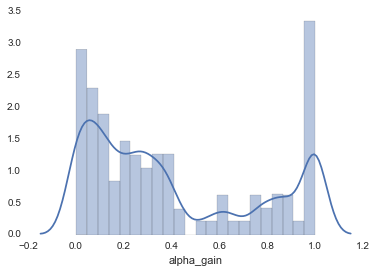

In [104]:
sns.distplot(model_train.alpha_gain)

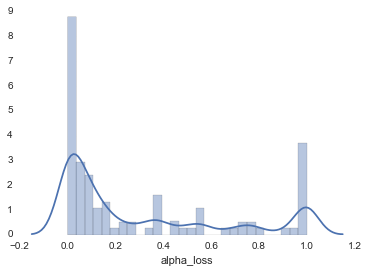

In [105]:
sns.distplot(model_train.alpha_loss)

In [106]:
model_train.beta.describe()

count    24984.000000
mean         1.708127
std          4.425168
min          0.000706
25%          0.136403
50%          0.245617
75%          0.738151
max         20.000000
Name: beta, dtype: float64

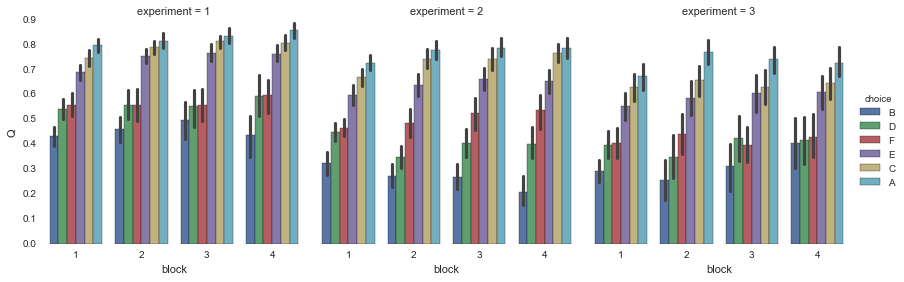

In [107]:
sns.factorplot(y='Q',x='block',hue='choice',hue_order=['B','D','F','E','C','A'],col='experiment',units='ID',
               kind='bar',ci=68,data=model_train)

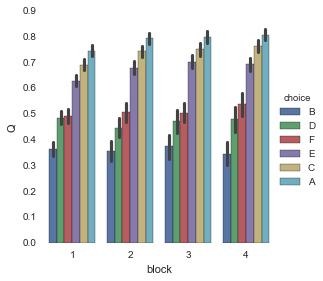

In [108]:
sns.factorplot(y='Q',x='block',hue='choice',hue_order=['B','D','F','E','C','A'],units='ID',
               kind='bar',ci=68,data=model_train)

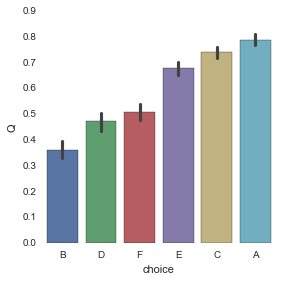

In [109]:
sns.factorplot(y='Q',x='choice',order=['B','D','F','E','C','A'],units='ID',
               kind='bar',ci=68,data=model_train)

In [110]:
# Experiment x Block x Choice ANOVA reveals only a main effect of Choice
model_train.trial_type = model_train.trial_type.astype(str)
%Rpush model_train
%R model_train$experiment <- as.factor(model_train$experiment)
%R model_train$block <- as.factor(model_train$block)
# %R str(model_train)

# All pairwise are sig (after correction for MC) except for D vs. F, which is p = 0.08
%R q.aov <- aov_ez(dv='Q',id='ID',within=c('choice','block'),between='experiment',data=model_train,\
                  anova_table=list(correction='GG',es='pes'))
%R print(q.aov)
%R q.lsm <- lsmeans(q.aov, ~choice)
%R print(q.lsm)
%R print(pairs(q.lsm))

Anova Table (Type 3 tests)

Response: Q
                   Effect            df  MSE         F pes p.value
1              experiment         2, 43 1.74    2.47 + .10     .10
2                  choice   1.78, 76.50 0.12 78.48 *** .65  <.0001
3       experiment:choice   3.56, 76.50 0.12      0.80 .04     .51
4                   block   1.78, 76.35 0.03      0.79 .02     .44
5        experiment:block   3.55, 76.35 0.03      1.84 .08     .14
6            choice:block  8.53, 366.98 0.01      0.79 .02     .62
7 experiment:choice:block 17.07, 366.98 0.01      0.99 .04     .47

Sphericity correction method: GG 


 choice    lsmean         SE    df  lower.CL  upper.CL
 A      0.7712191 0.02590245 83.75 0.7197071 0.8227312
 B      0.3879114 0.02650381 91.58 0.3352693 0.4405535
 C      0.7167108 0.02589704 83.68 0.6652088 0.7682127
 D      0.4719917 0.02624594 88.17 0.4198348 0.5241486
 E      0.6485431 0.02601678 85.21 0.5968166 0.7002696
 F      0.5137339 0.02613807 86.77 0.4617797 0.5656881

Results are averaged over the levels of: experiment, block 
Confidence level used: 0.95 


 contrast    estimate         SE  df t.ratio p.value
 A - B     0.38330774 0.01569824 473  24.417  <.0001
 A - C     0.05450838 0.01401225 473   3.890  0.0016
 A - D     0.29922748 0.01501984 473  19.922  <.0001
 A - E     0.12267605 0.01432766 473   8.562  <.0001
 A - F     0.25748526 0.01472976 473  17.481  <.0001
 B - C    -0.32879936 0.01567445 473 -20.977  <.0001
 B - D    -0.08408025 0.01644554 473  -5.113  <.0001
 B - E    -0.26063169 0.01595329 473 -16.337  <.0001
 B - F    -0.12582248 0.01620570 473  -7.764  <.0001
 C - D     0.24471910 0.01501172 473  16.302  <.0001
 C - E     0.06816767 0.01431799 473   4.761  <.0001
 C - F     0.20297688 0.01471562 473  13.793  <.0001
 D - E    -0.17655143 0.01533101 473 -11.516  <.0001
 D - F    -0.04174223 0.01554511 473  -2.685  0.0801
 E - F     0.13480921 0.01504659 473   8.959  <.0001

Results are averaged over the levels of: experiment, block 
P value adjustment: tukey method for comparing a family of 6 estimates 


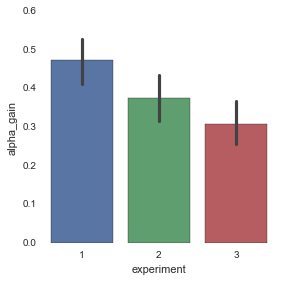

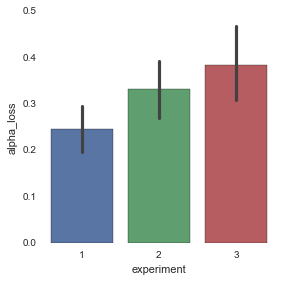

In [111]:
# How about the learning rates? This is unexpected, looks like decreasing/increasing trends for alpha gain/loss

sns.factorplot(y='alpha_gain',x='experiment',units='ID',kind='bar',ci=68,data=model_train)
sns.factorplot(y='alpha_loss',x='experiment',units='ID',kind='bar',ci=68,data=model_train)

In [112]:
# No effect of Experiment on alpha gain or loss--makes life a little easier:)

%R ag.aov <- aov_ez(dv='alpha_gain',id='ID',between='experiment',data=model_train)
%R print(ag.aov)

%R al.aov <- aov_ez(dv='alpha_loss',id='ID',between='experiment',data=model_train)
%R print(al.aov)

Anova Table (Type 3 tests)

Response: alpha_gain
      Effect     df  MSE    F ges p.value
1 experiment 2, 102 0.12 1.75 .03     .18


Anova Table (Type 3 tests)

Response: alpha_loss
      Effect     df  MSE    F ges p.value
1 experiment 2, 102 0.13 1.23 .02     .30


t(104) = 2.36, p = 0.020, g = 0.230


(2.3582317222259994, 0.020231673204520632, 0.23014398589012336)

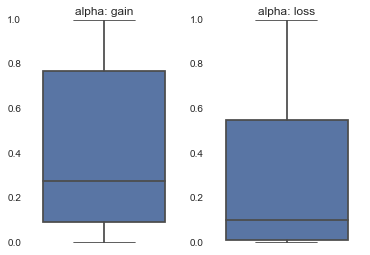

In [113]:
alphas = misc.MakeFrame(in_df=model_train,id_vars=['experiment','ID'],dv=['alpha_gain','alpha_loss'])
alphas.head()

fig = plt.figure()
ax1 = fig.add_subplot(121)
sns.boxplot(y=alphas.alpha_gain)
ax1.set_ylabel('')
ax1.set_title('alpha: gain')
ax2 = fig.add_subplot(122)
sns.boxplot(y=alphas.alpha_loss)
ax2.set_ylabel('')
ax2.set_title('alpha: loss')

# No significant difference b/w alphas by paired t-test
misc.ttest_2s(alphas.alpha_gain,alphas.alpha_loss,paired=True)

In [114]:
alphas.head()

,experiment,ID,alpha_gain,alpha_loss
0,1,1_1,0.054345,0.035916
1,1,1_10,0.091854,0.016004
2,1,1_11,0.080857,0.060097
3,1,1_12,0.549253,0.281051
4,1,1_13,1.000000,0.955768


In [115]:
# Rather than running one-way ANOVAs on Experiment for each type of alpha, I should really run an Experiment x Type
# ANOVA. This way I can do that ('along' for 'alpha in long format')
# Dang, I get a significant Experiment x Type interaction . . . only sig effect is Gain > Loss in E1, nowhere else.
along = pd.melt(alphas,id_vars=['experiment','ID'],var_name='alpha_type')
along.alpha_type = along.alpha_type.replace({'alpha_gain':'gain','alpha_loss':'loss'})
along.tail()

%Rpush along
%R along$experiment <- as.factor(along$experiment)
%R str(along)

%R along.aov <- aov_ez(dv='value',id='ID',within='alpha_type',between='experiment',data=along,\
                      anova_table=list(correction='GG',es='pes'))
%R print(along.aov)

%R along.lsm <- lsmeans(along.aov, ~experiment * alpha_type)
%R print(along.lsm)
%R print(pairs(along.lsm))

'data.frame':	210 obs. of  4 variables:
 $ experiment: Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ ID        : Factor w/ 105 levels "1_1","1_10","1_11",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ alpha_type: Factor w/ 2 levels "gain","loss": 1 1 1 1 1 1 1 1 1 1 ...
 $ value     : num  0.0543 0.0919 0.0809 0.5493 1 ...


Anova Table (Type 3 tests)

Response: value
                 Effect     df  MSE      F   pes p.value
1            experiment 2, 102 0.17   0.01 .0003     .99
2            alpha_type 1, 102 0.09   2.20   .02     .14
3 experiment:alpha_type 2, 102 0.09 4.35 *   .08     .02

Sphericity correction method: GG 


 experiment alpha_type    lsmean         SE     df  lower.CL  upper.CL
 1          gain       0.4731850 0.05693353 173.24 0.3608124 0.5855577
 2          gain       0.3765906 0.05972539 180.19 0.2587395 0.4944417
 3          gain       0.3091793 0.07129623 196.77 0.1685764 0.4497821
 1          loss       0.2484021 0.05693353 173.24 0.1360295 0.3607748
 2          loss       0.3331767 0.05972539 180.19 0.2153256 0.4510278
 3          loss       0.3869522 0.07129623 196.77 0.2463493 0.5275550

Confidence level used: 0.95 


 contrast           estimate         SE     df t.ratio p.value
 1,gain - 2,gain  0.09659447 0.07818649 184.86   1.235  0.8189
 1,gain - 3,gain  0.16400579 0.09393158 184.86   1.746  0.5033
 1,gain - 1,loss  0.22478291 0.06124846 102.00   3.670  0.0051
 1,gain - 2,loss  0.14000838 0.07818649 184.86   1.791  0.4743
 1,gain - 3,loss  0.08623288 0.09393158 184.86   0.918  0.9415
 2,gain - 3,gain  0.06741132 0.09698115 184.86   0.695  0.9823
 2,gain - 1,loss  0.12818845 0.07818649 184.86   1.640  0.5735
 2,gain - 2,loss  0.04341392 0.06738795 102.00   0.644  0.9873
 2,gain - 3,loss -0.01036158 0.09698115 184.86  -0.107  1.0000
 3,gain - 1,loss  0.06077713 0.09393158 184.86   0.647  0.9872
 3,gain - 2,loss -0.02399740 0.09698115 184.86  -0.247  0.9999
 3,gain - 3,loss -0.07777290 0.09064929 102.00  -0.858  0.9555
 1,loss - 2,loss -0.08477453 0.07818649 184.86  -1.084  0.8872
 1,loss - 3,loss -0.13855003 0.09393158 184.86  -1.475  0.6806
 2,loss - 3,loss -0.05377550 0.09698115 184.86  -0.554 

In [116]:
def RunningTrials(data):
    '''Given block and trial numbers, return a continuous trial count.'''
    block, trial = data
    if block == 1:
        out = trial
    elif block == 2:
        out = trial + 60
    elif block == 3:
        out = trial + 120
    elif block == 4:
        out = trial + 180
    
    return out
model_train['trial_continuous'] = model_train[['block','trial']].apply(RunningTrials,axis=1)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/seaborn/algorithms.py:76: RuntimeWarning: Mean of empty slice
  boot_dist.append(func(*sample, **func_kwargs))


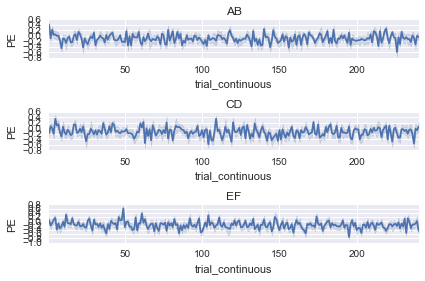

In [117]:
sns.set_style('darkgrid')

fig = plt.figure()
ax1 = fig.add_subplot(311)
sns.tsplot(model_train[model_train.pair == 'AB'],value='PE',unit='ID',time='trial_continuous',estimator=np.nanmean)
ax1.set_title('AB')
ax2 = fig.add_subplot(312)
sns.tsplot(model_train[model_train.pair == 'CD'],value='PE',unit='ID',time='trial_continuous',estimator=np.nanmean)
ax2.set_title('CD')
ax3 = fig.add_subplot(313)
sns.tsplot(model_train[model_train.pair == 'EF'],value='PE',unit='ID',time='trial_continuous',estimator=np.nanmean)
ax3.set_title('EF')
fig.tight_layout()

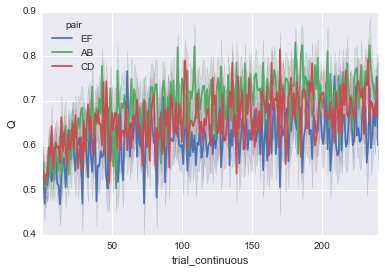

In [118]:
sns.set_style('darkgrid')
sns.tsplot(model_train,value='Q',unit='ID',time='trial_continuous',condition='pair',estimator=np.nanmean)

## Modeling test performance 

I'm not getting much from what's below . . . I think I did it correctly, but the alphas look extreme and, at any rate, the training_accuracy x reinforcement difference interaction makes me think that a slow learning system may not be driving test performance anyway. And overall, this feels a bit post-hoc . . . maybe worth revisiting but leaving it for the moment.

Frank et al. (2007) includes separate modeling for the test phase; a more sophisticated version of this is folded into OpAl (Collins & Frank, 2013), but let's start with the simpler approach. The idea is that during training, choices may be dominated by PFC-based systems that make rapid adjustments based on recent feedback that's held in working memory. All along, the basal ganglia is learning, and what it learns--about subtle differences in reinforcement probability--may play a large role during the test phase, when there's no further reinforcement. I don't know if this is true in our data . . . the Training Accuracy x Reinforcement Difference interaction plotted above seems to show that when people learn something during training, what they learn (a) is most readily applied to pairs characterized by large (less subtle) differences in reinforcement, and (b) is likely handled by the PFC. But this thinking may be off, and at any rate it won't hurt to run these models. 

Here's what the modeling will entail . . . we will fit the delta rule to the training trials, w/o including softmax, to get final Q-values. Then we will use those final Q-values in softmax to try to match test performance, extracting beta along the way. 

In [119]:
def RL_likelihood_test(params,train_df,test_df):
    '''Given alpha_gain and alpha_loss, iterate over the training data (train_df) to obtain final Q-values.
    Then use those plus beta to model the test choices (test_df), ultimately returning -logp. The goal is to
    identify a slow learning system that is active during training and may govern choices at test (in extinction).'''

    ag,al,b = params
    
    Q_train = {1:{1:0.5,6:0.5},2:{2:0.5,5:0.5},3:{3:0.5,4:0.5}} # All Q-values initialized to 0.5 (not good, not bad)

    for i, row_i in train_df.iterrows():
        Qs = Q_train[row_i.state] # Get the Q values for this state
        Q_Chosen = Qs[row_i.action] # Give me the Q value for the chosen stimulus
        for k in Qs.keys(): # Look through the stimuli . . . 
            if k != row_i.action: # . . . if you see a stimulus that's not the chosen stimulus . . . 
                Q_NotChosen = Qs[k] # . .. then that must be the not-chosen stimulus, so give me its Q-value.
                
        Q_new, PE = RL_eq(Q_old=Q_train[row_i.state][row_i.action],fdbk=row_i.reward,
                                             alpha_loss=al,alpha_gain=ag)
        Q_train[row_i.state][row_i.action] = Q_new
        
    # Basically, what we're doing here is moving the choice rule into the test phase . . . 
    Q_test = {}
    Q_test['A'] = Q_train[1][1]
    Q_test['C'] = Q_train[2][2]
    Q_test['E'] = Q_train[3][3]
    Q_test['F'] = Q_train[3][4]
    Q_test['D'] = Q_train[2][5]
    Q_test['B'] = Q_train[1][6]
    
    logp = 0
    for i, row_i in test_df.iterrows():
        left_stim = row_i.pair[0]
        right_stim = row_i.pair[1]
        Q_Chosen = Q_test[row_i.choice]
        
        if left_stim != row_i.choice:
            Q_NotChosen = Q_test[left_stim]
        else:
            Q_NotChosen = Q_test[right_stim]
            
        prob_chosen = SoftMax(Q_Chosen,Q_NotChosen,b)
        logp = logp + np.log(prob_chosen)

    # Use negative log likelihood because the optimizer will search for the minimum (thus = max LL).

    return -logp

In [120]:
# Find the optimum (test) alpha_gain, alpha_loss, and beta values for each subject, such that these parameters reflect
# learning during training but specifically predict choices at test.

def OptFit_test(train_df,test_df):
    '''Given a train_df that consists of state, action, reward cols, and a test_df that includes pair and choice
    columns, use fmin to find best-fitting alpha gain, alpha loss, and beta.'''
    
    opt_final = (0,99999999) 
    
    # Optimize the model fit. For each subject, try three different sets of starting params to avoid converge fails.
    for params in [(0.1,0.1,1),(0.5,0.5,10),(0.9,0.9,19)]:
        
        opt_new = sp.optimize.fmin(RL_likelihood_test, [params[0], params[1], params[2]], args=(train_df,test_df), 
                                   full_output=True)
    
        if opt_new[1] < opt_final[1]:
            opt_final = opt_new
    
    test_ag = opt_new[0][0]
    test_al = opt_new[0][1]
    test_b = opt_new[0][2]
    min_val = opt_new[1]
    
    if test_ag < 0:
        test_ag = 0
    elif test_ag > 1:
        test_ag = 1
    
    if test_al < 0:
        test_al = 0
    elif test_al > 1:
        test_al = 1
           
    if test_b < 0:
        test_b = 0  
    elif test_b > 20:
        test_b = 20
    
    # Now that we have the best values, let's add them to the test df.
    test_df['test_alpha_gain'] = test_ag
    test_df['test_alpha_loss'] = test_al
    test_df['test_beta'] = test_b
    
    # Last thing--we want to know what the final Q' values are. So now go through the training_df, with the best fitting alphas, and 
    # generate PE and Q' on each trial. The final Q' for each stimulus is what the slow learning system used to guide test choices.
    PEts = []
    Qts = [] # Instead of Q', 'Qt' for Q at test . . .
    
    Q = {1:{1:0.5,6:0.5},2:{2:0.5,5:0.5},3:{3:0.5,4:0.5}} # Q-values initialized to 0.5, as usual

    for i, row_i in train_df.iterrows():
        Q_new, PE = RL_eq(Q_old=Q[row_i.state][row_i.action],fdbk=row_i.reward,
                                             alpha_loss=test_al,alpha_gain=test_ag)
        Q[row_i.state][row_i.action] = Q_new
        Qts.append(Q_new)
        PEts.append(PE)
    train_df['Q_test'] = Qts
    train_df['PE_test'] = PEts # This is a bit non-sensical but it's the PEs during the training phase given the Qts . . . 
            
    return (train_df,test_df)

The cell below is commented out because it takes a LONG time to run, and once it's been run there's typically no need to re-run it . . . but if such a need arises, uncomment and go to town . . . 

In [121]:
# And fit the model . . .

# train_out = []
# test_out = []

# for sub in train.ID.unique():
#     train_df = model_train[model_train.ID == sub]
#     test_df = test[test.ID == sub]
#     new_train_df, new_test_df = OptFit_test(train_df,test_df)
#     train_out.append(new_train_df)
#     test_out.append(new_test_df)

# model_train = pd.concat(train_out)
# model_test = pd.concat(test_out)

# model_train.to_csv(path2asys + 'model_train.csv', index=False)
# model_test.to_csv(path2asys + 'model_test.csv', index=False)

In [122]:
# Import the CSVs w/o re-running everything
model_train = pd.read_csv(path2asys + 'model_train.csv')
model_test = pd.read_csv(path2asys + 'model_test.csv')

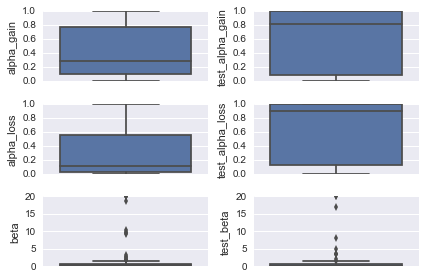

In [123]:
# Okay, let's compare the alphas and betas for the models fit to training vs. test.
# Those test values just don't look right to me . . . 

df_train = misc.MakeFrame(in_df=model_train,dv=['alpha_gain','alpha_loss','beta'],id_vars=['experiment','ID'])
df_test = misc.MakeFrame(in_df=model_test,dv=['test_alpha_gain','test_alpha_loss','test_beta'],
                         id_vars=['experiment','ID'])

fig = plt.figure()
ax1 = fig.add_subplot(321)
sns.boxplot(y='alpha_gain',data=df_train,ax=ax1)
ax2 = fig.add_subplot(322)
sns.boxplot(y='test_alpha_gain',data=df_test,ax=ax2)
ax3 = fig.add_subplot(323)
sns.boxplot(y='alpha_loss',data=df_train,ax=ax3)
ax4 = fig.add_subplot(324)
sns.boxplot(y='test_alpha_loss',data=df_test,ax=ax4)
ax5 = fig.add_subplot(325)
sns.boxplot(y='beta',data=df_train,ax=ax5)
ax6 = fig.add_subplot(326)
sns.boxplot(y='test_beta',data=df_test,ax=ax6)
fig.tight_layout()

In [124]:
model_train.groupby('choice')['Q'].mean()

choice
A    0.788546
B    0.361468
C    0.738989
D    0.471522
E    0.677859
F    0.508617
Name: Q, dtype: float64

In [125]:
model_train.groupby('choice')['Q_test'].mean()

choice
A    0.677752
B    0.256708
C    0.611643
D    0.363150
E    0.549122
F    0.401597
Name: Q_test, dtype: float64

## Individual differences

Okay, so what's worth looking at as far as correlations go? Honestely, we have so few self-report measures, relatively speaking, that I'd include them all (all are relevant to the questions at hand). What PST measures? The alphas and betas from training, certainly. The final Q values, Choose A, Avoid B, and Choose A - Avoid B accuracy and (correct) RT, maybe WW, LL, WL accuracy and RT. How about training accuracy and test performance at each level of reinforcement difference? Yes, that actually seems like it's most promising. Also arousal and valence ratings for reward, zero, and reward - zero.

In [210]:
sr = misc.MakeFrame(in_df=selfrep,id_vars='ID',dv=['AES_total','BDI_total','BAS_D','BAS_FS','BAS_RR',
                                                   'BIS','MASQ_GDA','MASQ_AA','MASQ_GDD','MASQ_AD','WTAR_StdScore'])
sr.ID = sr.ID.astype(str)
corr = sr.corr()
corr

Item,AES_total,BDI_total,BAS_D,BAS_FS,BAS_RR,BIS,MASQ_GDA,MASQ_AA,MASQ_GDD,MASQ_AD,WTAR_StdScore
Item,,,,,,,,,,,
AES_total,1.000000,0.435633,-0.288879,-0.003621,-0.171349,0.048275,0.258312,0.241324,0.454713,0.638537,-0.214497
BDI_total,0.435633,1.000000,0.048849,0.205714,0.154871,0.386522,0.694804,0.555462,0.821107,0.523244,-0.006659
BAS_D,-0.288879,0.048849,1.000000,0.380759,0.409865,0.169050,0.112567,-0.082189,0.002424,-0.190432,-0.010240
BAS_FS,-0.003621,0.205714,0.380759,1.000000,0.381959,0.232718,0.277736,0.167586,0.224182,0.071286,0.092889
BAS_RR,-0.171349,0.154871,0.409865,0.381959,1.000000,0.349504,0.214359,0.148764,0.129974,-0.141442,0.179357
BIS,0.048275,0.386522,0.169050,0.232718,0.349504,1.000000,0.418046,0.327802,0.408835,0.233898,0.199715
MASQ_GDA,0.258312,0.694804,0.112567,0.277736,0.214359,0.418046,1.000000,0.698130,0.659216,0.227113,0.111683
MASQ_AA,0.241324,0.555462,-0.082189,0.167586,0.148764,0.327802,0.698130,1.000000,0.613061,0.152414,0.005169
MASQ_GDD,0.454713,0.821107,0.002424,0.224182,0.129974,0.408835,0.659216,0.613061,1.000000,0.495348,0.051133


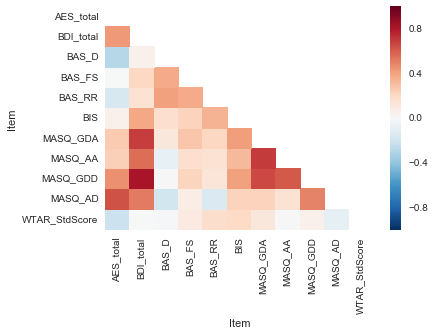

In [211]:
# Plot the correlation matrix for the self-report data only, with a mask for the upper triangle . . .
# (see here: http://seaborn.pydata.org/examples/many_pairwise_correlations.html)

sns.set_style('white')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask=mask)

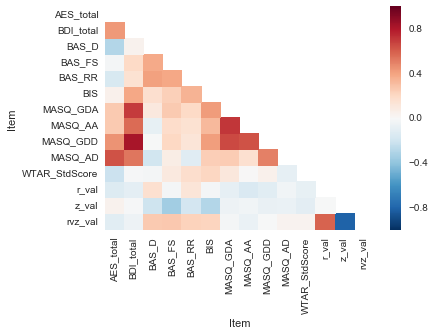

In [212]:
rate.head()
rval = rate[(rate.prompt == 'valence') & (rate.outcome == 'reward')]
rval = rval[['ID','rating']]
new_cols = ['ID','r_val']
rval.columns = new_cols
rval.reset_index(inplace=True,drop=True)

zval = rate[(rate.prompt == 'valence') & (rate.outcome == 'zero')]
zval = zval[['ID','rating']]
new_cols = ['ID','z_val']
zval.columns = new_cols
zval.reset_index(inplace=True,drop=True)

rate_wide = pd.merge(rval,zval,on='ID')
rate_wide['rvz_val'] = rate_wide.r_val - rate_wide.z_val
rate_wide.head()

sr = pd.merge(sr,rate_wide,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

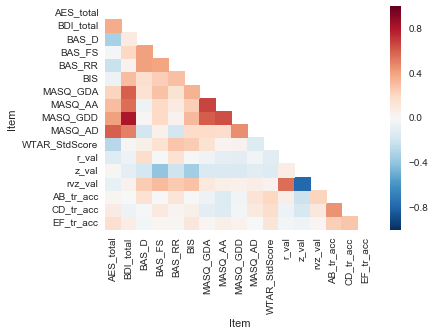

In [213]:
# Add accuracy values on AB, CD, EF training trials (averaged over blocks)
df = misc.MakeFrame(in_df=model_train,dv=['accuracy'],id_vars=['ID','pair'])
df = df.pivot(index='ID',columns='pair',values='accuracy')
df.reset_index(inplace=True)
new_cols = ['ID','AB_tr_acc','CD_tr_acc','EF_tr_acc']
df.columns = new_cols

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

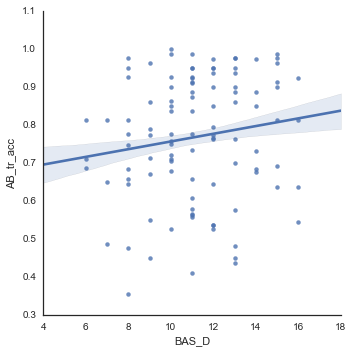

In [214]:
sns.lmplot(y='AB_tr_acc',x='BAS_D',units='ID',ci=68,data=sr)

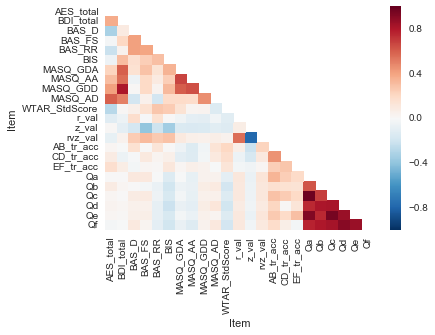

In [215]:
# Add Q values on training trials (averaged over blocks).
# Wow, the Q values really aren't correlated with anything except training accuracy . . . 
df = misc.MakeFrame(in_df=model_train,dv=['Q'],id_vars=['ID','choice'])
df = df.pivot(index='ID',columns='choice',values='Q')
df.reset_index(inplace=True)
new_cols = ['ID','Qa','Qb','Qc','Qd','Qe','Qf']
df.columns = new_cols
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

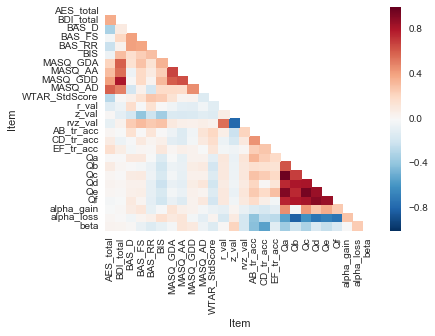

In [216]:
# Add alpha gain, alpha loss, and beta (from training) . . . none of these is strongly correlated with any sr 
# measures either . . . 
df = misc.MakeFrame(in_df=model_train,dv=['alpha_gain','alpha_loss','beta'],id_vars=['ID'])
# df.head()
sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

In [217]:
# Alright, let's add PST test data + SR . . . obvious places to start are Choose A and Avoid B . . . 
model_test.head()

,block,trial,left_stim_number,right_stim_number,response,RT,accuracy,experiment,subject,ID,...,outlier,pair,difference,choice,trial_type,con_trial_type,train_acc,test_alpha_gain,test_alpha_loss,test_beta
0,1,1,6,4,right,2.296,1,1,1,1_1,...,0,BF,20,F,AvoidB,LL,0.92887,0,0.007791,0
1,1,2,2,4,left,2.455,1,1,1,1_1,...,0,CF,30,C,neither,WL,0.92887,0,0.007791,0
2,1,3,3,2,left,2.479,0,1,1,1_1,...,0,EC,10,E,neither,WW,0.92887,0,0.007791,0
3,1,4,1,5,left,0.522,1,1,1,1_1,...,0,AD,50,A,ChooseA,WL,0.92887,0,0.007791,0
4,1,5,1,4,left,0.663,1,1,1,1_1,...,0,AF,40,A,ChooseA,WL,0.92887,0,0.007791,0


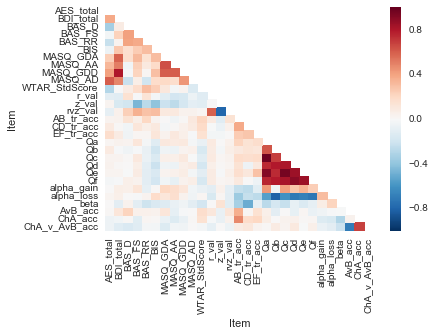

In [218]:
# Accuracy first . . . nothing super strong popping out
df = misc.MakeFrame(in_df=model_test[~(model_test.trial_type == 'neither')],dv='accuracy',id_vars=['ID','trial_type'])
df = df.pivot(index='ID',columns='trial_type',values='accuracy')
df.reset_index(inplace=True)
new_cols = ['ID','AvB_acc','ChA_acc']
df.columns = new_cols
df['ChA_v_AvB_acc'] = df.ChA_acc - df.AvB_acc
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

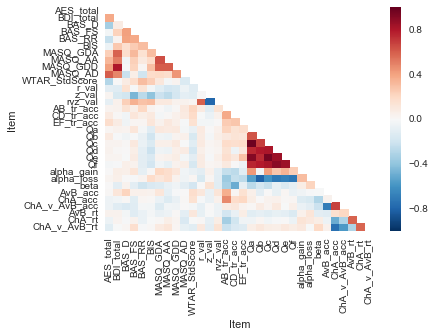

In [219]:
# Now correct RT . . . correlated with ChA and AvB accuracy, not much else . . . 
df = misc.MakeFrame(in_df=model_test[~((model_test.trial_type == 'neither') | (model_test.accuracy == 0))],
                    dv='RT',id_vars=['ID','trial_type'])
df = df.pivot(index='ID',columns='trial_type',values='RT')
df.reset_index(inplace=True)
new_cols = ['ID','AvB_rt','ChA_rt']
df.columns = new_cols
df['ChA_v_AvB_rt'] = df.ChA_rt - df.AvB_rt
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

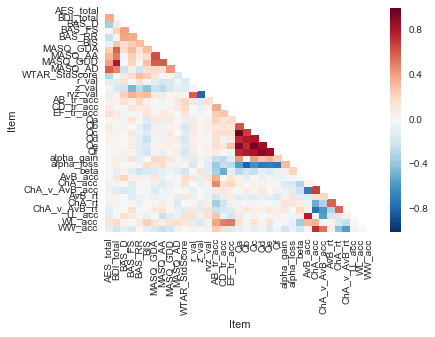

In [220]:
# Okay, accuracy as a consequence of conflict at test
df = misc.MakeFrame(in_df=model_test[~(model_test.con_trial_type == 'trained')],dv='accuracy',
                    id_vars=['ID','con_trial_type'])
df = df.pivot(index='ID',columns='con_trial_type',values='accuracy')
df.reset_index(inplace=True)
new_cols = ['ID','LL_acc','WL_acc','WW_acc']
df.columns = new_cols
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

(-0.19964910752356319, 0.048728741578608195)

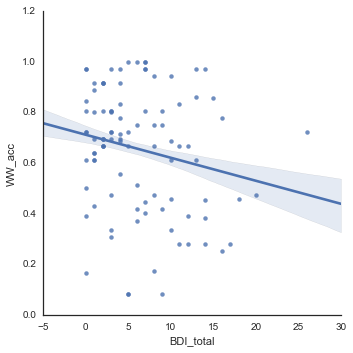

In [221]:
# Significant, barely . . . and the relationship with anhedonia is weaker . . . 
sns.lmplot(y='WW_acc',x='BDI_total',units='ID',ci=68,data=sr)
sp.stats.pearsonr(sr.WW_acc,sr.BDI_total)

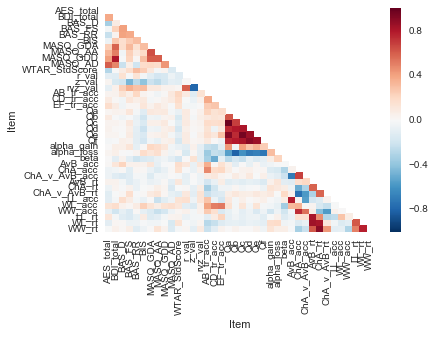

In [222]:
# Okay, RT as a consequence of conflict at test
df = misc.MakeFrame(in_df=model_test[~((model_test.con_trial_type == 'trained') | (model_test.accuracy == 0))],
                    dv='RT',id_vars=['ID','con_trial_type'])
df = df.pivot(index='ID',columns='con_trial_type',values='RT')
df.reset_index(inplace=True)
new_cols = ['ID','LL_rt','WL_rt','WW_rt']
df.columns = new_cols
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

(-0.1426227074963938, 0.16122890816162452)
(-0.15819474286523785, 0.11976313550349173)


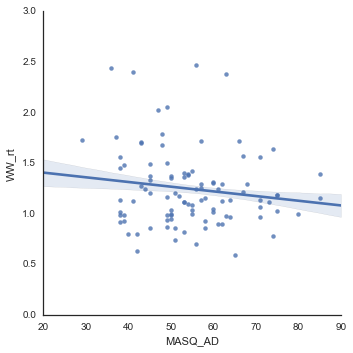

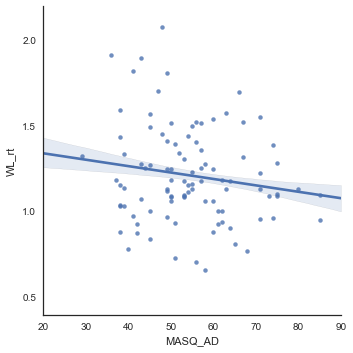

In [223]:
# Neither of these is significant . . .  
sns.lmplot(y='WW_rt',x='MASQ_AD',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.WW_rt,sr.MASQ_AD)

sns.lmplot(y='WL_rt',x='MASQ_AD',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.WL_rt,sr.MASQ_AD)

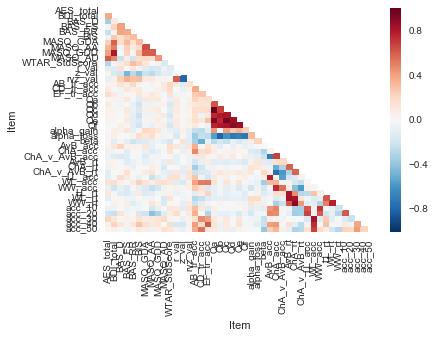

In [224]:
df = misc.MakeFrame(in_df=model_test[~(model_test.con_trial_type == 'trained')],dv='accuracy',id_vars=['ID','difference'])
df = df.pivot(index='ID',columns='difference',values='accuracy')
df.reset_index(inplace=True)

new_cols = ['ID','acc_10','acc_20','acc_30','acc_40','acc_50']
df.columns = new_cols
df.head()

sr = pd.merge(sr,df,on='ID')
# sr.head()

# Plot the heatmap again . . .
corr = sr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask)

(-0.17508124350026635, 0.084649495978188175)
(-0.40963890898904592, 2.8076685841183762e-05)


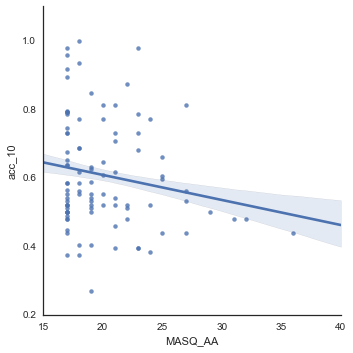

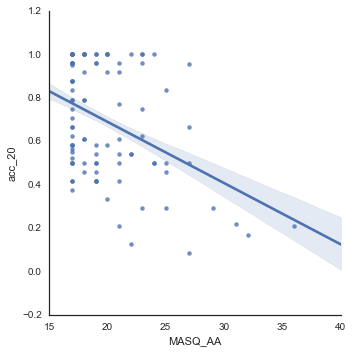

In [225]:
# MASQ-AA: trend with acc_10, highly significant with acc_20 . . . but so few subjects with high MASQ-AA scores . . . 
# . . . and of course I did not anticpate this relationship at all . . .

sns.lmplot(y='acc_10',x='MASQ_AA',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.acc_10,sr.MASQ_AA)

sns.lmplot(y='acc_20',x='MASQ_AA',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.acc_20,sr.MASQ_AA)

(0.62414227028987701, 6.5884088496290256e-12)
(0.70678097509718008, 4.2248537005268717e-16)
(0.31125749128789343, 0.0018107446129366942)


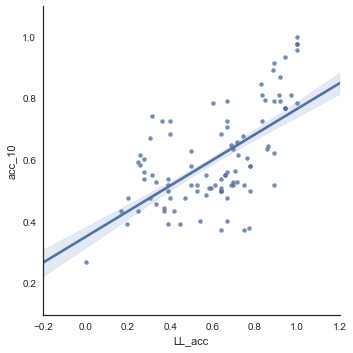

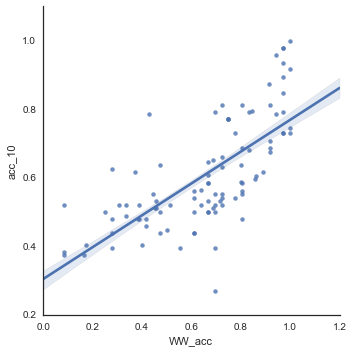

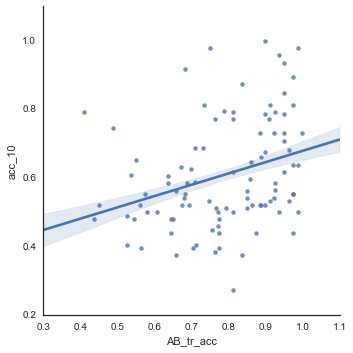

In [226]:
# No surprise to see acc_10 correlated with WW and LL, but interesting that it's also correlated with AB training.

sns.lmplot(y='acc_10',x='LL_acc',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.acc_10,sr.LL_acc)

sns.lmplot(y='acc_10',x='WW_acc',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.acc_10,sr.WW_acc)

sns.lmplot(y='acc_10',x='AB_tr_acc',units='ID',ci=68,data=sr)
print sp.stats.pearsonr(sr.acc_10,sr.AB_tr_acc)

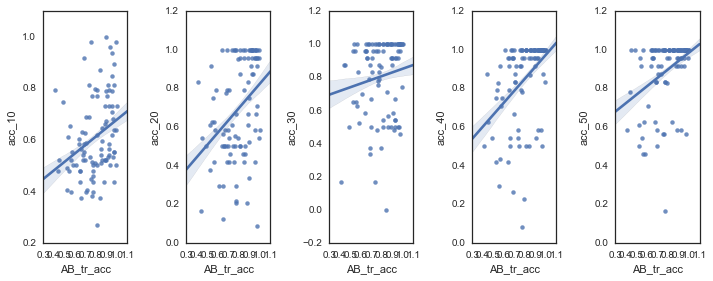

In [227]:
# Obviously needs some work, but this will show that AB training accuracy, despite its simplicity, is correlated
# with all levels of test accuracy as a function of the difference in reinforcement rates for the two stimuli being
# tested, all the way from very hard (10% diff) to very easy (50% diff). May be useful for thinking about why an AB
# training deficit in MDD is noteworthy.

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(151)
sns.regplot(y='acc_10',x='AB_tr_acc',units='ID',ci=68,data=sr,ax=ax1)
ax2 = fig.add_subplot(152)
sns.regplot(y='acc_20',x='AB_tr_acc',units='ID',ci=68,data=sr,ax=ax2)
ax3 = fig.add_subplot(153)
sns.regplot(y='acc_30',x='AB_tr_acc',units='ID',ci=68,data=sr,ax=ax3)
ax4 = fig.add_subplot(154)
sns.regplot(y='acc_40',x='AB_tr_acc',units='ID',ci=68,data=sr,ax=ax4)
ax5 = fig.add_subplot(155)
sns.regplot(y='acc_50',x='AB_tr_acc',units='ID',ci=68,data=sr,ax=ax5)
fig.tight_layout()

In general, I'm not seeing much wrt to correlations b/w behavior and self-report. But let's spend some more time on the correlations b/w different aspects of behavior. You might first plot all the correls with ratings, as there seem to be a few sig ones in there, and then I might plot all the correls with MASQ-AD, AES, BDI, and BAS-D as the clearest tests of the core hypothesis. The entire heatmap is tough to view on its own, so make separate heatmaps for those variables.

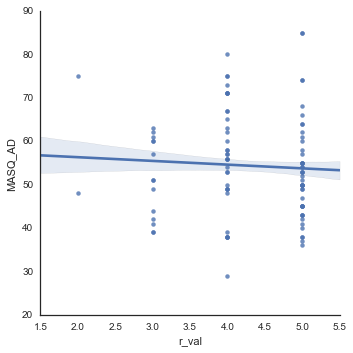

In [228]:
sns.lmplot(y='MASQ_AD',x='r_val',units='ID',ci=68,data=sr)

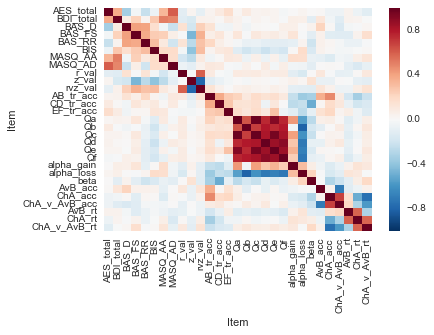

In [229]:
# Let's look again at the core stuff . . . focusing on relationships b/w self-report and behavior, the strongest
# positive relationships I see are between reward-zero valence (rvz_val) and the BIS/BAS measures. AvoidB accuracy
# looks like it might be correlated with BDI and BAS-D, and I think AB training accuracy is correlated with BAS-D and
# BAS-RR. Let's look at those in more detail . . . 
sr = sr[['ID', 'AES_total', 'BDI_total', 'BAS_D', 'BAS_FS', 'BAS_RR',
       'BIS', 'MASQ_AA', 'MASQ_AD','r_val', 'z_val', 'rvz_val', 'AB_tr_acc',
       'CD_tr_acc', 'EF_tr_acc', 'Qa', 'Qb', 'Qc', 'Qd', 'Qe', 'Qf', 'alpha_gain',
       'alpha_loss', 'beta', 'AvB_acc', 'ChA_acc', 'ChA_v_AvB_acc',
       'AvB_rt', 'ChA_rt', 'ChA_v_AvB_rt']]
corr = sr.corr()
sns.heatmap(corr)

BAS_D, r = 0.24, p = 0.0177726194952
BAS_FS, r = 0.34, p = 0.000760432305903
BAS_RR, r = 0.31, p = 0.00231793835667
BIS, r = 0.32, p = 0.00148944160985


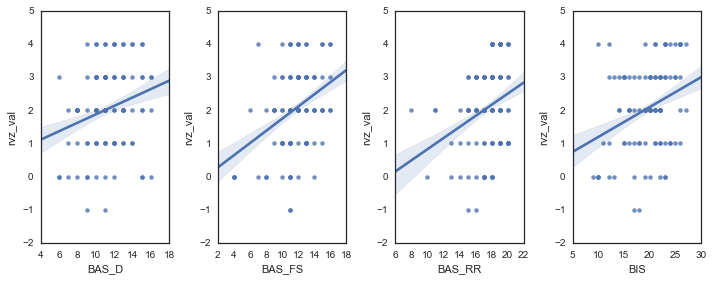

In [230]:
# Reward-Zero valence and BIS/BAS . . . all relationships are sig, weird that that includes BIS, but the cell
# below shows that all BIS/BAS scales are positively correlated.

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(141)
sns.regplot(y='rvz_val',x='BAS_D',units='ID',ci=68,data=sr,ax=ax1)

ax2 = fig.add_subplot(142)
sns.regplot(y='rvz_val',x='BAS_FS',units='ID',ci=68,data=sr,ax=ax2)

ax3 = fig.add_subplot(143)
sns.regplot(y='rvz_val',x='BAS_RR',units='ID',ci=68,data=sr,ax=ax3)

ax4 = fig.add_subplot(144)
sns.regplot(y='rvz_val',x='BIS',units='ID',ci=68,data=sr,ax=ax4)
fig.tight_layout()

# Need to drop NaNs for sp.stats.pearsonr
clean = sr.dropna()
r,p = sp.stats.pearsonr(clean.rvz_val,clean.BAS_D)
print 'BAS_D, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.rvz_val,clean.BAS_FS)
print 'BAS_FS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.rvz_val,clean.BAS_RR)
print 'BAS_RR, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.rvz_val,clean.BIS)
print 'BIS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)

In [231]:
sr[['BAS_D','BAS_FS','BAS_RR','BIS']].corr()

Item,BAS_D,BAS_FS,BAS_RR,BIS
Item,,,,
BAS_D,1.000000,0.409952,0.406078,0.169102
BAS_FS,0.409952,1.000000,0.381515,0.252098
BAS_RR,0.406078,0.381515,1.000000,0.312322
BIS,0.169102,0.252098,0.312322,1.000000


BAS_D, r = 0.16, p = 0.132682477223
BAS_FS, r = 0.09, p = 0.36605911261
BAS_RR, r = 0.22, p = 0.0351915675449
BIS, r = 0.03, p = 0.747064658416


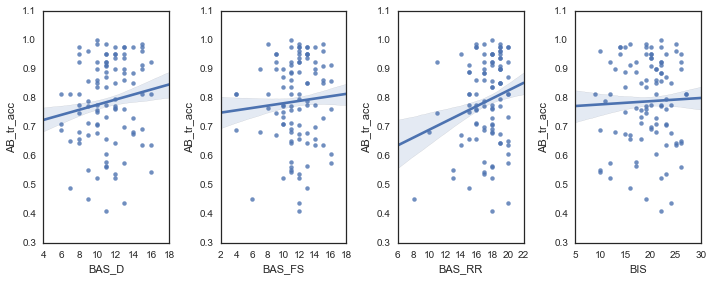

In [232]:
# Same but with AB training acc . . . only one that's significant is BAS-RR, and it's not great

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(141)
sns.regplot(y='AB_tr_acc',x='BAS_D',units='ID',ci=68,data=sr,ax=ax1)

ax2 = fig.add_subplot(142)
sns.regplot(y='AB_tr_acc',x='BAS_FS',units='ID',ci=68,data=sr,ax=ax2)

ax3 = fig.add_subplot(143)
sns.regplot(y='AB_tr_acc',x='BAS_RR',units='ID',ci=68,data=sr,ax=ax3)

ax4 = fig.add_subplot(144)
sns.regplot(y='AB_tr_acc',x='BIS',units='ID',ci=68,data=sr,ax=ax4)
fig.tight_layout()

# Need to drop NaNs for sp.stats.pearsonr
clean = sr.dropna()
r,p = sp.stats.pearsonr(clean.AB_tr_acc,clean.BAS_D)
print 'BAS_D, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AB_tr_acc,clean.BAS_FS)
print 'BAS_FS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AB_tr_acc,clean.BAS_RR)
print 'BAS_RR, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AB_tr_acc,clean.BIS)
print 'BIS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)

BAS_D, r = 0.22, p = 0.033160695632
BAS_FS, r = 0.07, p = 0.506565667449
BAS_RR, r = 0.06, p = 0.579439041377
BIS, r = 0.06, p = 0.580504273902


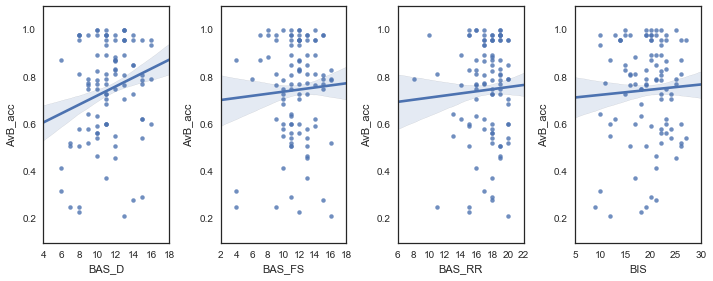

In [233]:
# Same but with Avoid B accuracy . . . a relationship with BAS-D, nothing spectacular

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(141)
sns.regplot(y='AvB_acc',x='BAS_D',units='ID',ci=68,data=sr,ax=ax1)

ax2 = fig.add_subplot(142)
sns.regplot(y='AvB_acc',x='BAS_FS',units='ID',ci=68,data=sr,ax=ax2)

ax3 = fig.add_subplot(143)
sns.regplot(y='AvB_acc',x='BAS_RR',units='ID',ci=68,data=sr,ax=ax3)

ax4 = fig.add_subplot(144)
sns.regplot(y='AvB_acc',x='BIS',units='ID',ci=68,data=sr,ax=ax4)
fig.tight_layout()

# Need to drop NaNs for sp.stats.pearsonr
clean = sr.dropna()
r,p = sp.stats.pearsonr(clean.AvB_acc,clean.BAS_D)
print 'BAS_D, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AvB_acc,clean.BAS_FS)
print 'BAS_FS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AvB_acc,clean.BAS_RR)
print 'BAS_RR, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.AvB_acc,clean.BIS)
print 'BIS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)

BAS_D, r = -0.19, p = 0.0661689137623
BAS_FS, r = -0.43, p = 1.07915400936e-05
BAS_RR, r = -0.28, p = 0.00529838523047
BIS, r = -0.43, p = 1.49398179734e-05


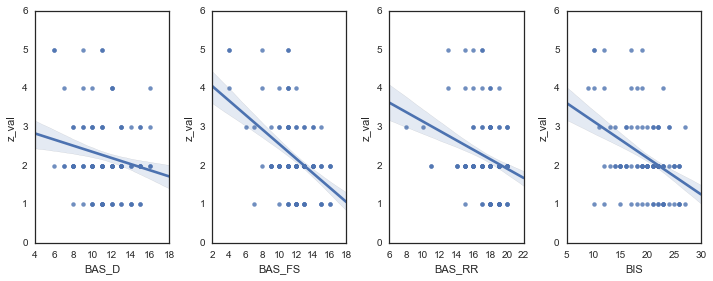

In [234]:
# In terms of negative relationships, looks like there's something b/w zero valence and BIS/BAS.
# Indeed, every relationship except that with BAS-D is significant, and even that's a trend . . FWIW, I checked
# on the BIS/BAS scoring and it looks correct judging by what Carver has printed on his website.

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(141)
sns.regplot(y='z_val',x='BAS_D',units='ID',ci=68,data=sr,ax=ax1)

ax2 = fig.add_subplot(142)
sns.regplot(y='z_val',x='BAS_FS',units='ID',ci=68,data=sr,ax=ax2)

ax3 = fig.add_subplot(143)
sns.regplot(y='z_val',x='BAS_RR',units='ID',ci=68,data=sr,ax=ax3)

ax4 = fig.add_subplot(144)
sns.regplot(y='z_val',x='BIS',units='ID',ci=68,data=sr,ax=ax4)
fig.tight_layout()

# Need to drop NaNs for sp.stats.pearsonr
clean = sr.dropna()
r,p = sp.stats.pearsonr(clean.z_val,clean.BAS_D)
print 'BAS_D, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.z_val,clean.BAS_FS)
print 'BAS_FS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.z_val,clean.BAS_RR)
print 'BAS_RR, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.z_val,clean.BIS)
print 'BIS, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)

In [235]:
# The strongest relationship with MASQ-AD appears to be Choose A RT, and it's not close to significant
sp.stats.pearsonr(clean.MASQ_AD,clean.ChA_rt)

(-0.15749494453268631, 0.12743900110332221)

Qa, r = -0.12, p = 0.253319422862
Qc, r = -0.14, p = 0.163321848255
Qe, r = -0.15, p = 0.14248920146
Qf, r = -0.18, p = 0.0779096542605
Qd, r = -0.22, p = 0.0318531776363
Qb, r = -0.20, p = 0.0558874315799


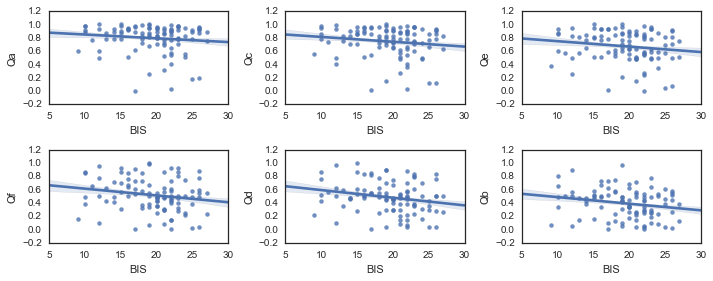

In [236]:
# BIS is negatively correlated with Q values . . . not super-strong, but interesting.

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(231)
sns.regplot(y='Qa',x='BIS',units='ID',ci=68,data=sr,ax=ax1)

ax2 = fig.add_subplot(232)
sns.regplot(y='Qc',x='BIS',units='ID',ci=68,data=sr,ax=ax2)

ax3 = fig.add_subplot(233)
sns.regplot(y='Qe',x='BIS',units='ID',ci=68,data=sr,ax=ax3)

ax4 = fig.add_subplot(234)
sns.regplot(y='Qf',x='BIS',units='ID',ci=68,data=sr,ax=ax4)
fig.tight_layout()

ax5 = fig.add_subplot(235)
sns.regplot(y='Qd',x='BIS',units='ID',ci=68,data=sr,ax=ax5)

ax6 = fig.add_subplot(236)
sns.regplot(y='Qb',x='BIS',units='ID',ci=68,data=sr,ax=ax6)
fig.tight_layout()

# Need to drop NaNs for sp.stats.pearsonr
clean = sr.dropna()
r,p = sp.stats.pearsonr(clean.Qa,clean.BIS)
print 'Qa, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.Qc,clean.BIS)
print 'Qc, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.Qe,clean.BIS)
print 'Qe, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)

r,p = sp.stats.pearsonr(clean.Qf,clean.BIS)
print 'Qf, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.Qd,clean.BIS)
print 'Qd, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)
r,p = sp.stats.pearsonr(clean.Qb,clean.BIS)
print 'Qb, r = ' + '{:.2f}'.format(r) + ', p = ' + str(p)